# Exploratory data analysis and pre-processing

## Install packages

In [ ]:
# Setting the current working directory
import os
path = "/Users/fleurroijen/Library/Mobile Documents/com~apple~CloudDocs/Documents/University/Tilburg University MSc/TiU Spring 24:25/Master Thesis : Data Science in Action/Predicting-Tax-Avoidance"
os.chdir(path)

In [2]:
# Installing the required packages
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install optuna
!pip install sklearn
!pip install matplotlib
!pip install xgboost
!pip install warnings
!pip install imblearn
!pip install missingno
!pip install feature_engine
!pip install -U imbalanced-learn
!pip install -U scikit-learn
!pip install scipy
!pip install joblib

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

In [3]:
# Loading the necessary packages
import datetime
import warnings
import pandas as pd
import numpy as np
from collections import Counter

# Data visualization
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pandas.plotting import register_matplotlib_converters
from scipy.stats import skew

# Feature engineering
from feature_engine.creation import CyclicalFeatures

# Hyperparameter tuning
import optuna
from optuna import Trial, visualization

# Oversampling
from imblearn.over_sampling import SMOTENC

# Scikit-learn modeling
import sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, average_precision_score
)

# XGBoost modeling
from xgboost import XGBClassifier

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Merging the datasets

In [4]:
# Loading the firm-specific data
df_firm_raw = pd.read_csv('firm-specific-data-2005-2023.csv')

In [5]:
# Getting a first impression of the firm-specific data
df_firm_raw.shape
df_firm_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84522 entries, 0 to 84521
Data columns (total 87 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gvkey     84522 non-null  int64  
 1   indfmt    84522 non-null  object 
 2   datafmt   84522 non-null  object 
 3   consol    84522 non-null  object 
 4   popsrc    84522 non-null  object 
 5   acctstd   84455 non-null  object 
 6   curcd     84522 non-null  object 
 7   fyear     84522 non-null  int64  
 8   fyr       84522 non-null  int64  
 9   pddur     84522 non-null  int64  
 10  datadate  84522 non-null  object 
 11  act       84304 non-null  float64
 12  ao        84181 non-null  float64
 13  ap        84235 non-null  float64
 14  apo       83931 non-null  float64
 15  at        84306 non-null  float64
 16  capx      71674 non-null  float64
 17  ceq       84297 non-null  float64
 18  ch        82081 non-null  float64
 19  che       84276 non-null  float64
 20  cogs      84201 non-null  fl

In [6]:
# Loading the statutory tax rate data
df_STR_raw = pd.read_excel('Statutory-Tax-Rates_0.xlsx', sheet_name=' CIT rates', header=3)

In [7]:
# Converting to csv and select the relevant data
df_STR_raw.to_csv('Statutory-Tax-Rates_0.csv', index=False)
df_STR_raw = df_STR_raw.iloc[0:27,1:31]
df_STR_raw = df_STR_raw.rename(columns={'Unnamed: 1':'country'})

In [8]:
# Reshaping the statutory tax rate data
df_STR_panel = df_STR_raw.set_index('country')
df_STR_panel = df_STR_panel.unstack().reset_index()
df_STR_panel = df_STR_panel.rename(columns={'level_0':'fyear', 0:'str'})

In [9]:
# Adding column containing country code to match the firm-specific dataset
def label_fic(row):
   if row['country'] == 'Austria':
      return 'AUT'
   if row['country'] == 'Belgium':
      return 'BEL'
   if row['country'] == 'Bulgaria':
      return 'BGR'
   if row['country'] == 'Croatia':
      return 'HRV'
   if row['country'] == 'Cyprus':
      return 'CYP'
   if row['country'] == 'Czechia':
      return 'CZE'
   if row['country'] == 'Denmark': 
      return 'DNK'
   if row['country'] == 'Estonia':
      return 'EST'
   if row['country'] == 'Finland':
      return 'FIN'
   if row['country'] == 'France':
      return 'FRA'
   if row['country'] == 'Germany':
      return 'DEU'
   if row['country'] == 'Greece':
      return 'GRC'
   if row['country'] == 'Hungary':
      return 'HUN'
   if row['country'] == 'Ireland':
      return 'IRL'
   if row['country'] == 'Italy':
      return 'ITA'
   if row['country'] == 'Latvia':
      return 'LVA'
   if row['country'] == 'Lithuania':
      return 'LTU'
   if row['country'] == 'Luxembourg':
      return 'LUX'
   if row['country'] == 'Malta':
      return 'MLT'
   if row['country'] == 'Netherlands':
      return 'NLD'
   if row['country'] == 'Poland':
      return 'POL'
   if row['country'] == 'Portugal':
      return 'PRT'
   if row['country'] == 'Romania':
      return 'ROU'
   if row['country'] == 'Slovakia':
      return 'SVK'
   if row['country'] == 'Slovenia':
      return 'SVN'
   if row['country'] == 'Spain':
      return 'ESP'
   if row['country'] == 'Sweden':
      return 'SWE'
   return 'Other'

df_STR_panel['fic'] = df_STR_panel.apply(label_fic, axis=1)

In [10]:
# Preparing the dataset before merging with firm-specific dataset
df_STR = df_STR_panel.drop('country', axis=1)
df_STR['str'] = df_STR['str'].astype(float)

In [11]:
# Merging the datasets
df_comb = pd.merge(df_firm_raw, df_STR, on=['fic','fyear'], how='left')

In [12]:
# Selecting only years 2005-2023
df_comb = df_comb[(df_comb['fyear'] >= 2005) & (df_comb['fyear'] <= 2023)]

In [13]:
# Getting a brief overview of what is in the dataset
num_companies = df_comb['conm'].nunique()
num_countries = df_comb['fic'].nunique()
num_years = df_comb['fyear'].nunique()

print(f"Number of unique companies: {num_companies}")
print(f"Number of unique countries: {num_countries}")
print(f"Number of years in the dataset: {num_years}")
print(f"Shape of the dataset:", df_comb.shape)

Number of unique companies: 6970
Number of unique countries: 27
Number of years in the dataset: 19
Shape of the dataset: (84359, 88)


In [14]:
# Creating a new column for region
def label_region(row):
   if row['fic'] in ('AUT', 'BEL', 'DNK', 'FRA', 'DEU', 'IRL', 'LUX', 'NLD'):
      return 'West'
   if row['fic'] in ('BGR', 'HRV', 'CZE', 'EST', 'HUN', 'LVA', 'LTU', 'POL', 'ROU', 'SVK', 'SVN'):
      return 'East'
   if row['fic'] in ('CYP', 'GRC', 'ITA', 'MLT', 'PRT', 'ESP'):
      return 'South'
   if row['fic'] in ('FIN', 'SWE'):
      return 'North'
   return 'Other'

df_comb['region'] = df_comb.apply(label_region, axis=1)

In [15]:
# Generating ID columns for separating and merging later
df_comb["id_cat"] = df_comb.index
df_comb["id_num"] = df_comb.index

In [16]:
# Checking whether the ID columns are equal (should result in 0 if they are equal)
df_comb['id_num'] = df_comb['id_num']
df_comb['id_cat'] = df_comb['id_cat']
columns_not_equal = df_comb['id_num'] != df_comb['id_cat']
print(columns_not_equal.sum())

0


In [17]:
# Converting the ID columns to the same datatype as the dataset they will belong to
df_comb["id_cat"] = df_comb.index.astype(str)
df_comb["id_num"] = df_comb.index.astype(int)

In [18]:
# Checking the dataset
df_comb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84359 entries, 0 to 84521
Data columns (total 91 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gvkey     84359 non-null  int64  
 1   indfmt    84359 non-null  object 
 2   datafmt   84359 non-null  object 
 3   consol    84359 non-null  object 
 4   popsrc    84359 non-null  object 
 5   acctstd   84292 non-null  object 
 6   curcd     84359 non-null  object 
 7   fyear     84359 non-null  int64  
 8   fyr       84359 non-null  int64  
 9   pddur     84359 non-null  int64  
 10  datadate  84359 non-null  object 
 11  act       84141 non-null  float64
 12  ao        84018 non-null  float64
 13  ap        84072 non-null  float64
 14  apo       83768 non-null  float64
 15  at        84143 non-null  float64
 16  capx      71525 non-null  float64
 17  ceq       84134 non-null  float64
 18  ch        81920 non-null  float64
 19  che       84113 non-null  float64
 20  cogs      84039 non-null  float64

In [19]:
# Converting categorical variables into string format
# This includes: fyear, gvkey, fyr, pddur, naics and sic
df_comb['fyear'] = df_comb['fyear'].astype(str)
df_comb['gvkey'] = df_comb['gvkey'].astype(str)
df_comb['fyr'] = df_comb['fyr'].astype(str)
df_comb['pddur'] = df_comb['pddur'].astype(str)
df_comb['naics'] = df_comb['naics'].astype(str)
df_comb['sic'] = df_comb['sic'].astype(str)

### Creating an industry variable

### First using naics

In [20]:
# Getting the first two elements of the naics code to get the industry
def first2naics(s):
    return s[:2]

df_comb['industry'] = df_comb['naics'].apply(first2naics)

In [21]:
# Adding the naics industry names
naics_dict = {
    '11': 'Agriculture',
    '21': 'Mining',
    '22': 'Utilities',
    '23': 'Construction',
    '31': 'Manufacturing',
    '32': 'Manufacturing',
    '33': 'Manufacturing',
    '42': 'Wholesale',
    '44': 'Retail',
    '45': 'Retail',
    '48': 'Transportation',
    '49': 'Transportation',
    '51': 'Information',
    '52': 'Finance',
    '53': 'RealEstate',
    '54': 'Services',
    '55': 'Management',
    '56': 'AdminSupport',
    '61': 'Education',
    '62': 'HealthCare',
    '71': 'ArtsEntertainment',
    '72': 'Hospitality',
    '81': 'OtherServices',
    '92': 'PublicAdmin',
    '99': 'Nonclassifiable'
}

df_comb['industry'] = df_comb['industry'].map(naics_dict)

In [22]:
print(df_comb['industry'].unique())

['Manufacturing' 'Transportation' 'Information' 'Utilities'
 'Nonclassifiable' 'Construction' 'Management' 'Retail' 'Wholesale'
 'Mining' 'Hospitality' 'Services' 'AdminSupport' 'Agriculture'
 'RealEstate' 'ArtsEntertainment' 'Education' 'HealthCare' 'Finance'
 'OtherServices' nan]


In [23]:
# Checking unknown industry codes
(df_comb['naics'] == 'nan').sum()

55

In [24]:
industry_check = df_comb[df_comb['industry'].isna()]
industry_check.head()

,gvkey,indfmt,datafmt,consol,popsrc,acctstd,curcd,fyear,fyr,pddur,...,fic,city,conml,naics,sic,str,region,id_cat,id_num,industry
14996,213563,INDL,HIST_STD,C,I,DI,LTL,2005,12,12,...,LTU,Mazeikiai,"Mazeikiu Nafta AB, Mazeikiu",nan,2911.0,15.0,East,14996,14996,NaN
14997,213563,INDL,HIST_STD,C,I,DI,LTL,2006,12,12,...,LTU,Mazeikiai,"Mazeikiu Nafta AB, Mazeikiu",nan,2911.0,19.0,East,14997,14997,NaN
14998,213563,INDL,HIST_STD,C,I,DI,LTL,2007,12,12,...,LTU,Mazeikiai,"Mazeikiu Nafta AB, Mazeikiu",nan,2911.0,18.0,East,14998,14998,NaN
14999,213563,INDL,HIST_STD,C,I,DI,LTL,2008,12,12,...,LTU,Mazeikiai,"Mazeikiu Nafta AB, Mazeikiu",nan,2911.0,15.0,East,14999,14999,NaN
15000,213563,INDL,HIST_STD,C,I,DI,LTL,2009,12,12,...,LTU,Mazeikiai,"Mazeikiu Nafta AB, Mazeikiu",nan,2911.0,20.0,East,15000,15000,NaN


### Then replacing the industry unknowns using sic industry codes

In [25]:
def first2sic(s):
    return s[:2]

mask = df_comb['naics'] == 'nan'
df_comb.loc[mask, 'industry'] = df_comb.loc[mask, 'sic'].apply(first2sic)

In [26]:
sic_dict = {
    '01': 'Agriculture',
    '02': 'Agriculture',
    '10': 'Mining',
    '11': 'Mining',
    '12': 'Mining',
    '13': 'Mining',
    '14': 'Mining',
    '15': 'Construction',
    '16': 'Construction',
    '17': 'Construction',
    '18': 'NotUsed',
    '19': 'NotUsed',
    '20': 'Manufacturing',
    '21': 'Manufacturing',
    '22': 'Manufacturing',
    '23': 'Manufacturing',
    '24': 'Manufacturing',
    '25': 'Manufacturing',
    '26': 'Manufacturing',
    '27': 'Manufacturing',
    '28': 'Manufacturing',
    '29': 'Manufacturing',
    '30': 'Manufacturing',
    '31': 'Manufacturing',
    '32': 'Manufacturing',
    '33': 'Manufacturing',
    '34': 'Manufacturing',
    '35': 'Manufacturing',
    '36': 'Manufacturing',
    '37': 'Manufacturing',
    '38': 'Manufacturing',
    '39': 'Manufacturing',
    '40': 'Transportation',
    '41': 'Transportation',
    '42': 'Transportation',
    '43': 'Transportation',
    '44': 'Transportation',
    '45': 'Transportation',
    '46': 'Transportation',
    '47': 'Transportation',
    '48': 'Transportation',
    '49': 'Transportation',
    '50': 'Wholesale',
    '51': 'Wholesale',
    '52': 'Wholesale',
    '53': 'Wholesale',
    '54': 'Wholesale',
    '55': 'Wholesale',
    '56': 'Wholesale',
    '57': 'Wholesale',
    '58': 'Wholesale',
    '59': 'Wholesale',
    '60': 'Retail',
    '61': 'Retail',
    '62': 'Retail',
    '63': 'Retail',
    '64': 'Retail',
    '65': 'Retail',
    '66': 'Retail',
    '67': 'Retail',
    '68': 'Retail',
    '69': 'Retail',
    '70': 'Retail',
    '71': 'Retail',
    '72': 'Retail',
    '73': 'Retail',
    '74': 'Retail',
    '75': 'Retail',
    '76': 'Retail',
    '77': 'Retail',
    '78': 'Retail',
    '79': 'Retail',
    '80': 'Retail',
    '81': 'Services',
    '82': 'Services',
    '83': 'Services',
    '84': 'Services',
    '85': 'Services',
    '86': 'Services',
    '87': 'Services',
    '88': 'Services',
    '89': 'Services',
    '90': 'PublicAdmin',
    '91': 'PublicAdmin',
    '92': 'PublicAdmin',
    '93': 'PublicAdmin',
    '94': 'PublicAdmin',
    '95': 'PublicAdmin',
    '96': 'PublicAdmin',
    '97': 'PublicAdmin',
    '98': 'PublicAdmin',
    '99': 'Nonclassified'
}

mask = df_comb['industry'].astype(str).str.isdigit()
df_comb.loc[mask, 'industry'] = df_comb.loc[mask, 'industry'].map(sic_dict)

In [27]:
print(df_comb['industry'].unique())

['Manufacturing' 'Transportation' 'Information' 'Utilities'
 'Nonclassifiable' 'Construction' 'Management' 'Retail' 'Wholesale'
 'Mining' 'Hospitality' 'Services' 'AdminSupport' 'Agriculture'
 'RealEstate' 'ArtsEntertainment' 'Education' 'HealthCare' 'Finance'
 'OtherServices']


In [28]:
# Group all industry classifications into groups
industry_group_map = {
    'Mining': 'Agriculture',
    'Agriculture': 'Agriculture',

    'Manufacturing': 'Industrial',
    'Construction': 'Industrial',
    'Utilities': 'Industrial',

    'Transportation': 'Transport',

    'Information': 'Information',

    'Services': 'Services',
    'AdminSupport': 'Services',
    'OtherServices': 'Services',

    'Retail': 'Trade',
    'Wholesale': 'Trade',

    'RealEstate': 'Finance',
    'Finance': 'Finance',
    'Management': 'Finance',

    'HealthCare': 'Social',
    'Education': 'Social',

    'Hospitality': 'Leisure',
    'ArtsEntertainment': 'Leisure',

    'Nonclassifiable': 'Nonclassifiable'
}

df_comb['industry'] = df_comb['industry'].map(industry_group_map)

In [29]:
# Checking for missing values in the industry column
(df_comb['industry'].isna()).sum()

0

In [30]:
# Checking for infinite values in the dataset
print('Number of infinite values in dataset: ', df_comb[df_comb == np.inf].count().sum())

Number of infinite values in dataset:  0


In [31]:
df_comb.head()

,gvkey,indfmt,datafmt,consol,popsrc,acctstd,curcd,fyear,fyr,pddur,...,fic,city,conml,naics,sic,str,region,id_cat,id_num,industry
0,1166,INDL,HIST_STD,C,I,US,EUR,2005,12,12,...,NLD,Almere,ASM International NV,333242.0,3559.0,31.5,West,0,0,Industrial
1,1166,INDL,HIST_STD,C,I,US,EUR,2006,12,12,...,NLD,Almere,ASM International NV,333242.0,3559.0,29.6,West,1,1,Industrial
2,1166,INDL,HIST_STD,C,I,US,EUR,2007,12,12,...,NLD,Almere,ASM International NV,333242.0,3559.0,25.5,West,2,2,Industrial
3,1166,INDL,HIST_STD,C,I,US,EUR,2008,12,12,...,NLD,Almere,ASM International NV,333242.0,3559.0,25.5,West,3,3,Industrial
4,1166,INDL,HIST_STD,C,I,US,EUR,2009,12,12,...,NLD,Almere,ASM International NV,333242.0,3559.0,25.5,West,4,4,Industrial


In [32]:
df_comb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84359 entries, 0 to 84521
Data columns (total 92 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gvkey     84359 non-null  object 
 1   indfmt    84359 non-null  object 
 2   datafmt   84359 non-null  object 
 3   consol    84359 non-null  object 
 4   popsrc    84359 non-null  object 
 5   acctstd   84292 non-null  object 
 6   curcd     84359 non-null  object 
 7   fyear     84359 non-null  object 
 8   fyr       84359 non-null  object 
 9   pddur     84359 non-null  object 
 10  datadate  84359 non-null  object 
 11  act       84141 non-null  float64
 12  ao        84018 non-null  float64
 13  ap        84072 non-null  float64
 14  apo       83768 non-null  float64
 15  at        84143 non-null  float64
 16  capx      71525 non-null  float64
 17  ceq       84134 non-null  float64
 18  ch        81920 non-null  float64
 19  che       84113 non-null  float64
 20  cogs      84039 non-null  float64

In [33]:
df_comb.shape

(84359, 92)

### Constructing the target variables

In [34]:
# Renaming the dataset
df_target = df_comb

In [35]:
# Adding the effective tax rate
df_target['etr'] = (df_target['txpd'] / df_target['ebit']) * 100

#### Constructing the industry-mean target variable

In [36]:
# Adding a binary target variable for tax avoidance based on the industry-year median
def bottom_quantile(x, q=0.3):
    return x < x.quantile(q)

df_target['tax_avoidance'] = df_target.groupby(['industry', 'fyear'])['etr']\
                        .transform(bottom_quantile)

In [37]:
df_target['tax_avoidance'].value_counts(normalize=True)

tax_avoidance
False    0.826385
True     0.173615
Name: proportion, dtype: float64

In [38]:
df_target['tax_avoidance'] = df_target['tax_avoidance'].astype(bool)

#### Creating lagged features from the previous year to predict current year tax avoidance

In [39]:
# Change id_num into a string
df_target['id_num'] = df_target['id_num'].astype(str)

In [40]:
df_target = df_target.sort_values(by=['conm', 'fyear'])
feature_cols = list(df_target.select_dtypes(include='number').columns)

In [41]:
# Creating lagged versions of all features
for col in feature_cols:
    df_target[f'{col}_lag1'] = df_target.groupby('conm')[col].shift(1)

In [42]:
# Dropping all original columns
numeric_cols = df_target.select_dtypes(include='number').columns
cols_to_drop = [col for col in numeric_cols if not col.endswith('_lag1')]
df_lagged = df_target.drop(columns=cols_to_drop)

In [43]:
df_lagged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84359 entries, 75058 to 60069
Data columns (total 94 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gvkey          84359 non-null  object 
 1   indfmt         84359 non-null  object 
 2   datafmt        84359 non-null  object 
 3   consol         84359 non-null  object 
 4   popsrc         84359 non-null  object 
 5   acctstd        84292 non-null  object 
 6   curcd          84359 non-null  object 
 7   fyear          84359 non-null  object 
 8   fyr            84359 non-null  object 
 9   pddur          84359 non-null  object 
 10  datadate       84359 non-null  object 
 11  conm           84359 non-null  object 
 12  costat         84359 non-null  object 
 13  fic            84359 non-null  object 
 14  city           84213 non-null  object 
 15  conml          84359 non-null  object 
 16  naics          84359 non-null  object 
 17  sic            84359 non-null  object 
 18  region 

In [44]:
# Dropping all data from 2023 as those do not contain lagged features
df_lagged = df_lagged[df_lagged['fyear'] != '2023']

In [45]:
# Changing the datatype of tax_avoidance to boolean
df_lagged.loc[:, 'tax_avoidance'] = df_lagged['tax_avoidance'].astype(bool)

In [46]:
# Changing the datatype of 'fyear' back to string
df_lagged.loc[:, 'fyear'] = df_lagged['fyear'].astype(int).astype(str)

#### Checking for infinite values

In [47]:
# Checking for infinite values in the dataset
print('Number of infinite values in dataset: ', df_lagged[df_lagged == np.inf].count().sum())

Number of infinite values in dataset:  8


In [48]:
# Removing any infinite values from the data
df_lagged = df_lagged.replace([np.inf, -np.inf], np.nan)

In [49]:
# Checking the dataset
df_lagged.head()

,gvkey,indfmt,datafmt,consol,popsrc,acctstd,curcd,fyear,fyr,pddur,...,wcapopc_lag1,xacc_lag1,xint_lag1,xlr_lag1,xopr_lag1,xpp_lag1,xrd_lag1,xsga_lag1,str_lag1,etr_lag1
75058,326410,INDL,HIST_STD,C,I,DI,EUR,2016,12,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75059,326410,INDL,HIST_STD,C,I,DI,EUR,2017,12,12,...,-88.999,106.038,24.815,NaN,2042.224,1.215,NaN,355.865,29.8,0.143978
75060,326410,INDL,HIST_STD,C,I,DI,EUR,2018,12,12,...,-102.022,102.422,8.724,NaN,2309.189,0.000,NaN,468.135,29.9,0.042821
75061,326410,INDL,HIST_STD,C,I,DI,EUR,2019,12,12,...,-383.347,93.221,4.651,NaN,2942.741,0.000,NaN,503.932,29.9,1.067567
75062,326410,INDL,HIST_STD,C,I,DI,EUR,2020,12,12,...,-121.314,92.627,0.652,NaN,2710.833,0.000,NaN,315.267,29.9,4.110388


In [50]:
df_lagged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80330 entries, 75058 to 60069
Data columns (total 94 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gvkey          80330 non-null  object 
 1   indfmt         80330 non-null  object 
 2   datafmt        80330 non-null  object 
 3   consol         80330 non-null  object 
 4   popsrc         80330 non-null  object 
 5   acctstd        80268 non-null  object 
 6   curcd          80330 non-null  object 
 7   fyear          80330 non-null  object 
 8   fyr            80330 non-null  object 
 9   pddur          80330 non-null  object 
 10  datadate       80330 non-null  object 
 11  conm           80330 non-null  object 
 12  costat         80330 non-null  object 
 13  fic            80330 non-null  object 
 14  city           80191 non-null  object 
 15  conml          80330 non-null  object 
 16  naics          80330 non-null  object 
 17  sic            80330 non-null  object 
 18  region 

## Exploratory Data Analysis

In [51]:
# Renaming the dataset
df_eda = df_lagged

In [52]:
# Checking the dataset
pd.set_option("display.max_columns", None)
df_eda.head()

,gvkey,indfmt,datafmt,consol,popsrc,acctstd,curcd,fyear,fyr,pddur,datadate,conm,costat,fic,city,conml,naics,sic,region,id_cat,id_num,industry,tax_avoidance,act_lag1,ao_lag1,ap_lag1,apo_lag1,at_lag1,capx_lag1,ceq_lag1,ch_lag1,che_lag1,cogs_lag1,dc_lag1,dd1_lag1,dlc_lag1,dltt_lag1,dp_lag1,dpc_lag1,dvt_lag1,ea_lag1,ebit_lag1,ebitda_lag1,emp_lag1,fca_lag1,gdwl_lag1,ib_lag1,icapt_lag1,intan_lag1,invt_lag1,ivst_lag1,lco_lag1,lct_lag1,lo_lag1,lse_lag1,lt_lag1,oancf_lag1,oiadp_lag1,oibdp_lag1,pi_lag1,ppegt_lag1,ppent_lag1,pstk_lag1,re_lag1,recco_lag1,rect_lag1,rectr_lag1,revt_lag1,sale_lag1,sco_lag1,spi_lag1,sppiv_lag1,teq_lag1,txc_lag1,txdb_lag1,txdc_lag1,txdi_lag1,txditc_lag1,txo_lag1,txp_lag1,txpd_lag1,txt_lag1,txw_lag1,wcap_lag1,wcapopc_lag1,xacc_lag1,xint_lag1,xlr_lag1,xopr_lag1,xpp_lag1,xrd_lag1,xsga_lag1,str_lag1,etr_lag1
75058,326410,INDL,HIST_STD,C,I,DI,EUR,2016,12,12,2016-12-31,1&1 AG,A,DEU,Montabaur,1&1 AG,517.0,4813.0,West,75058,75058,Information,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75059,326410,INDL,HIST_STD,C,I,DI,EUR,2017,12,12,2017-12-31,1&1 AG,A,DEU,Montabaur,1&1 AG,517.0,4813.0,West,75059,75059,Information,True,263.535,300.257,890.290,0.0,1843.259,26.919,-452.260,4.562,4.562,1690.066,122.248,16.332,16.333,1086.819,8.610,8.610,98.6,0.0,379.224,387.834,NaN,0.083,506.482,203.610,674.000,749.655,39.286,0.000,140.106,1046.729,79.340,1843.259,2256.078,210.826,379.224,387.834,354.580,771.478,528.915,0.0,615.289,14.479,170.810,156.331,2430.058,2430.058,0.0,0.016,-0.189,-412.819,116.166,43.190,-4.481,-4.481,43.190,0.0,14.692,0.546,111.685,0.0,-783.194,-88.999,106.038,24.815,NaN,2042.224,1.215,NaN,355.865,29.8,0.143978
75060,326410,INDL,HIST_STD,C,I,DI,EUR,2018,12,12,2018-12-31,1&1 AG,A,DEU,Montabaur,1&1 AG,517.0,4813.0,West,75060,75060,Information,True,656.553,228.519,451.410,0.0,4735.708,15.556,3805.080,149.681,151.504,1823.607,79.414,0.529,3.606,0.267,64.088,64.088,282.8,0.0,439.036,503.124,3.194,0.260,2932.943,293.748,3805.347,3834.357,46.467,1.823,220.227,675.243,9.612,4735.708,930.628,347.610,439.036,503.124,431.330,25.255,14.356,0.0,1163.554,249.142,442.126,192.984,2812.313,2812.313,0.0,0.607,14.540,3805.080,140.261,245.506,-19.303,-19.302,245.506,0.0,50.306,0.188,120.959,0.0,-18.690,-102.022,102.422,8.724,NaN,2309.189,0.000,NaN,468.135,29.9,0.042821
75061,326410,INDL,HIST_STD,C,I,DI,EUR,2019,12,12,2019-12-31,1&1 AG,A,DEU,Montabaur,1&1 AG,517.0,4813.0,West,75061,75061,Information,False,1064.584,487.047,494.535,0.0,5246.640,15.489,4280.075,3.968,6.851,2400.966,320.525,0.267,0.267,0.000,154.696,154.696,NaN,0.0,565.023,719.719,3.210,0.218,2932.943,406.032,4280.075,3679.759,89.548,2.883,152.122,646.924,71.761,5246.640,966.565,155.552,565.023,719.719,562.575,24.525,13.842,0.0,1653.248,76.776,763.804,687.028,3662.460,3662.460,0.0,1.986,-1.766,4280.075,168.922,247.880,-12.378,-12.379,247.880,0.0,37.985,6.032,156.543,0.0,417.660,-383.347,93.221,4.651,NaN,2942.741,0.000,NaN,503.932,29.9,1.067567
75062,326410,INDL,HIST_STD,C,I,DI,EUR,2020,12,12,2020-12-31,1&1 AG,A,DEU,Montabaur,1&1 AG,517.0,4813.0,West,75062,75062,Information,False,1309.225,473.268,345.663,0.0,6461.944,20.452,4640.846,31.785,32.480,2342.091,293.828,7.573,7.573,40.215,155.014,155.014,8.8,0.0,808.999,964.013,3.163,0.414,2932.943,373.620,4681.061,4615.755,79.227,0.695,195.659,548.895,1002.240,6461.944,1821.098,375.707,808.999,964.013,522.436,82.275,62.018,0.0,2018.055,27.893,969.594,941.701,3674.846,3674.846,0.0,-287.275,-0.158,4640.846,166.834,229.748,-18.018,-18.018,229.748,0.0,26.713,33.253,148.816,0.0,760.330,-121.314,92.627,0.652,NaN,2710.833,0.000,NaN,315.267,29.9,4.110388


In [53]:
# Checking the dimensions of the dataset
df_eda.shape

(80330, 94)

In [54]:
# Analyzing the data
df_eda.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
act_lag1,73209.0,1845.394482,23429.868774,-1.203000,12.418000,56.709000,314.323000,1987853.0
ao_lag1,73172.0,287.045862,3286.976625,-41.257000,0.230000,3.361500,26.201500,264581.0
ap_lag1,73190.0,513.867643,8089.001063,-0.217000,1.579000,9.944500,67.339750,848241.0
apo_lag1,73120.0,4.602029,205.195195,0.000000,0.000000,0.000000,0.000000,32566.0
at_lag1,73210.0,5338.604938,73661.465373,0.000000,26.987250,127.709000,751.486250,6494259.0
...,...,...,...,...,...,...,...,...
xpp_lag1,73145.0,37.363325,1129.434916,-3863.000000,0.000000,0.015000,1.075000,120748.0
xrd_lag1,23785.0,208.022902,1669.134216,-22.939000,0.942000,5.198000,30.500000,61005.0
xsga_lag1,73130.0,527.942914,5668.562047,0.000000,2.516250,15.564000,93.803000,355085.0
str_lag1,73371.0,25.789582,7.180420,10.000000,19.000000,26.000000,30.000000,44.4


In [55]:
# Checking the variance of the variables
df_eda.select_dtypes(include='number').var()

act_lag1     5.489588e+08
ao_lag1      1.080422e+07
ap_lag1      6.543194e+07
apo_lag1     4.210507e+04
at_lag1      5.426011e+09
                 ...     
xpp_lag1     1.275623e+06
xrd_lag1     2.786009e+06
xsga_lag1    3.213260e+07
str_lag1     5.155843e+01
etr_lag1     5.482018e+07
Length: 71, dtype: float64

In [56]:
# Checking the skewness of the variables
df_eda.select_dtypes(include='number').skew()

act_lag1      52.568491
ao_lag1       38.221345
ap_lag1       59.569296
apo_lag1     113.032304
at_lag1       54.158958
                ...    
xpp_lag1      71.517471
xrd_lag1      19.178835
xsga_lag1     38.964919
str_lag1       0.037822
etr_lag1     202.489260
Length: 71, dtype: float64

In [57]:
# Checking the unique values of the variables
df_eda.nunique()

gvkey         6962
indfmt           1
datafmt          1
consol           1
popsrc           1
             ...  
xpp_lag1     10495
xrd_lag1     12338
xsga_lag1    43940
str_lag1        63
etr_lag1     41159
Length: 94, dtype: int64

In [58]:
# Printing number of unique values per column for categorical variables
df_categorical_features = df_eda.select_dtypes(exclude='number')
for column in df_categorical_features.columns:
    nunique_values = df_categorical_features[column].nunique()
    print(f"Number of unique values in {column}: {nunique_values}")

Number of unique values in gvkey: 6962
Number of unique values in indfmt: 1
Number of unique values in datafmt: 1
Number of unique values in consol: 1
Number of unique values in popsrc: 1
Number of unique values in acctstd: 5
Number of unique values in curcd: 30
Number of unique values in fyear: 18
Number of unique values in fyr: 12
Number of unique values in pddur: 15
Number of unique values in datadate: 216
Number of unique values in conm: 6959
Number of unique values in costat: 2
Number of unique values in fic: 27
Number of unique values in city: 2175
Number of unique values in conml: 6956
Number of unique values in naics: 1004
Number of unique values in sic: 401
Number of unique values in region: 4
Number of unique values in id_cat: 80330
Number of unique values in id_num: 80330
Number of unique values in industry: 10
Number of unique values in tax_avoidance: 2


In [59]:
# Printing unique values for categorical columns with fewer than 10 unique values
for column in df_categorical_features.columns:
    unique_values = df_categorical_features[column].unique()
    if len(unique_values) < 20:
        print(f"Unique values in {column}: {unique_values}")
    else:
        print(f"Number of unique values in {column}: {len(unique_values)}")

Number of unique values in gvkey: 6962
Unique values in indfmt: ['INDL']
Unique values in datafmt: ['HIST_STD']
Unique values in consol: ['C']
Unique values in popsrc: ['I']
Unique values in acctstd: ['DI' 'DS' 'ND' nan 'US' 'DU']
Number of unique values in curcd: 30
Unique values in fyear: ['2016' '2017' '2018' '2019' '2020' '2021' '2022' '2005' '2006' '2007'
 '2008' '2009' '2010' '2011' '2012' '2013' '2014' '2015']
Unique values in fyr: ['12' '6' '2' '3' '10' '4' '9' '8' '11' '7' '5' '1']
Unique values in pddur: ['12' '6' '13' '14' '7' '10' '8' '9' '18' '15' '11' '17' '16' '3' '19']
Number of unique values in datadate: 216
Number of unique values in conm: 6959
Unique values in costat: ['A' 'I']
Number of unique values in fic: 27
Number of unique values in city: 2176
Number of unique values in conml: 6956
Number of unique values in naics: 1004
Number of unique values in sic: 401
Unique values in region: ['West' 'East' 'South' 'North']
Number of unique values in id_cat: 80330
Number of

In [60]:
# Computing correlation matrix
corr_matrix = df_eda.corr(numeric_only=True)
tax_avoidance_corr = corr_matrix['tax_avoidance'].drop('tax_avoidance')

# Getting top 10 positive correlations
N = 10
top_corr_tax_avoidance = tax_avoidance_corr.nlargest(N)  

# Getting top 10 negative correlations
bottom_corr_tax_avoidance = tax_avoidance_corr.nsmallest(N)  

# Reversing the order of bottom_corr_tax_avoidance (lowest correlation at the bottom)
bottom_corr_tax_avoidance_reversed = bottom_corr_tax_avoidance.iloc[::-1] 

# Concatenating the positive correlations with the reversed negative correlations
top_and_bottom_corr_ta = pd.concat([top_corr_tax_avoidance, bottom_corr_tax_avoidance_reversed])

print("Top correlations with 'tax_avoidance':")
for feature, correlation in top_and_bottom_corr_ta.items():
    print(f"{feature}: {correlation}")

Top correlations with 'tax_avoidance':
txdc_lag1: 0.022157661448827814
sppiv_lag1: 0.008857814740069915
spi_lag1: 0.0059615744686203915
wcapopc_lag1: 0.005595537182655038
txdi_lag1: 0.003750925955735733
fca_lag1: 0.0034883902608863777
pstk_lag1: -0.001067505890253938
sco_lag1: -0.0029110653097019668
etr_lag1: -0.0030631509399216294
apo_lag1: -0.004013059333974638
txdb_lag1: -0.0242898587781315
dvt_lag1: -0.028863899011383518
txt_lag1: -0.029319912723825017
txc_lag1: -0.029915767492726758
intan_lag1: -0.031140071043049063
gdwl_lag1: -0.0324004255606506
xrd_lag1: -0.040564138444827855
str_lag1: -0.04908957875281176
txpd_lag1: -0.053735047572733334
emp_lag1: -0.07765056998257659


#### Plots

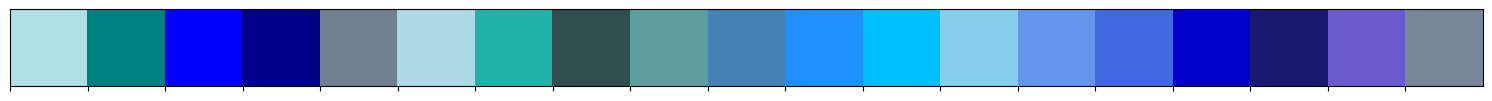

In [61]:
# Creating a colour palette for the plots
color_codes = [
    "powderblue", "teal", "blue", "darkblue", "slategrey", "lightblue",
    "lightseagreen", "darkslategray", "cadetblue", "steelblue", "dodgerblue",
    "deepskyblue", "skyblue", "cornflowerblue", "royalblue", "mediumblue",
    "midnightblue", "slateblue", "lightslategray"
]

# Displaying the color palette
sns.palplot(sns.color_palette(color_codes))

# Creating a ListedColormap from the HEX codes directly
colour_palette = ListedColormap(color_codes)
colour_palette_list = list(colour_palette.colors)

In [62]:
df_eda.loc[:, 'fyear'] = pd.to_numeric(df_eda['fyear'], errors='coerce')
df_eda = df_eda[(df_eda['fyear'] >= 2005) & (df_eda['fyear'] <= 2023)]
df_eda.loc[:, 'fyear'] = df_eda['fyear'].astype(int)

In [63]:
# Separating the numerical variables
df_eda_num = df_eda.select_dtypes(include='number')

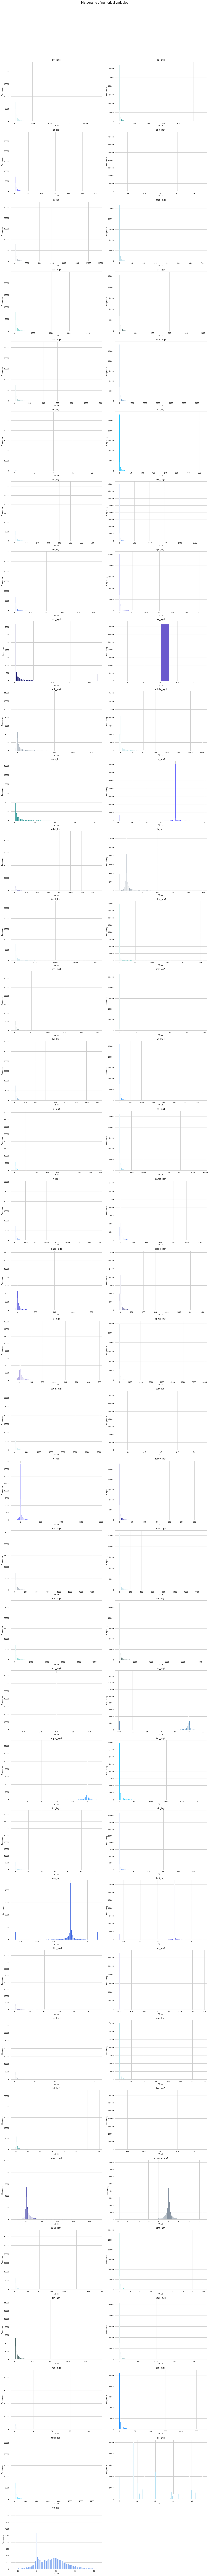

In [64]:
# Plotting general plots for the numerical variables
sns.set_style("whitegrid")

numerical_columns = df_eda_num.columns
num_plots = len(numerical_columns)
num_cols = 2
num_rows = -(-num_plots // num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

# Plotting each histogram
for i, col in enumerate(numerical_columns):
    ax = axes[i]
    data = df_eda_num[col].dropna()

    # Adjusting the bins based on the variation in the data
    data_range = data.max() - data.min()
    if data_range > 0:
        num_bins = int(np.sqrt(len(data)))
    else:
        num_bins = 10
    
    # Using 5th to 95th percentiles for variables with outliers
    data = np.clip(data, data.quantile(0.05), data.quantile(0.95))

    # Plotting the histogram
    ax.hist(data, bins=num_bins, color=color_codes[i % len(color_codes)])
    ax.set_title(col, fontsize=12)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Removing any unused subplots
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Histograms of numerical variables", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

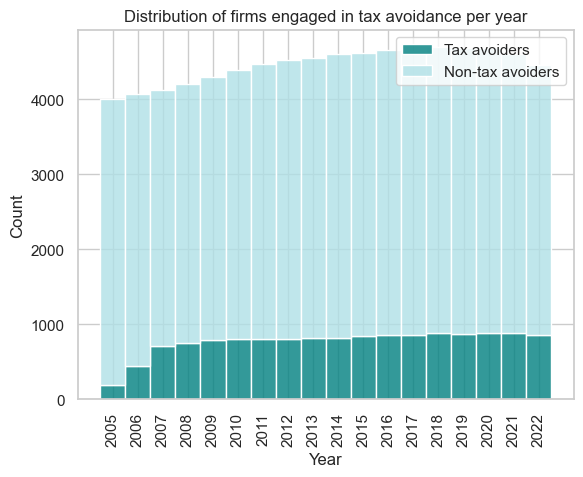

In [65]:
# Creating a barplot of the target variable per year
sns.set_theme(style="whitegrid")
sns.histplot(data=df_eda, x='fyear', hue='tax_avoidance', multiple="stack",
             alpha=0.8, palette=colour_palette_list, binwidth=1, discrete=True)
plt.title('Distribution of firms engaged in tax avoidance per year')
plt.xlabel('Year')
plt.ylabel('Count')
years = np.arange(2005, 2023)
plt.xticks(ticks=years, labels=years, rotation=90)
plt.legend(loc='upper right', labels=['Tax avoiders', 'Non-tax avoiders'])
plt.show()

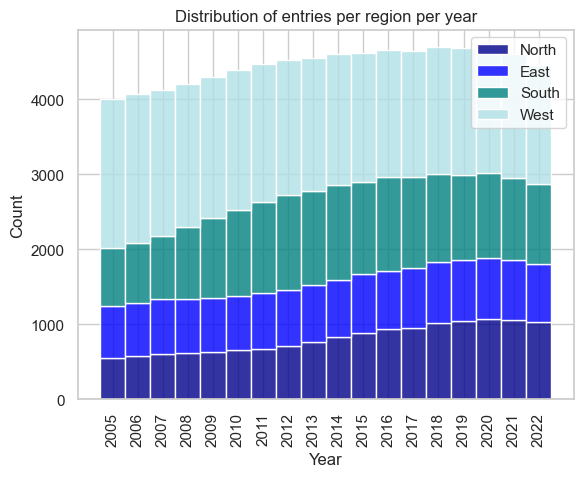

In [66]:
# Creating a barplot of entries per region per year
sns.set_theme(style="whitegrid")
sns.histplot(data=df_eda, x='fyear', hue='region', multiple="stack", alpha=0.8,
             palette=colour_palette_list, binwidth=1, discrete=True)
plt.title('Distribution of entries per region per year')
plt.xlabel('Year')
plt.ylabel('Count')
years = np.arange(2005, 2023)
plt.xticks(ticks=years, labels=years, rotation=0)
plt.xticks(rotation=90)
plt.legend(loc='upper right', labels=['North', 'East', 'South', 'West'])
plt.show()

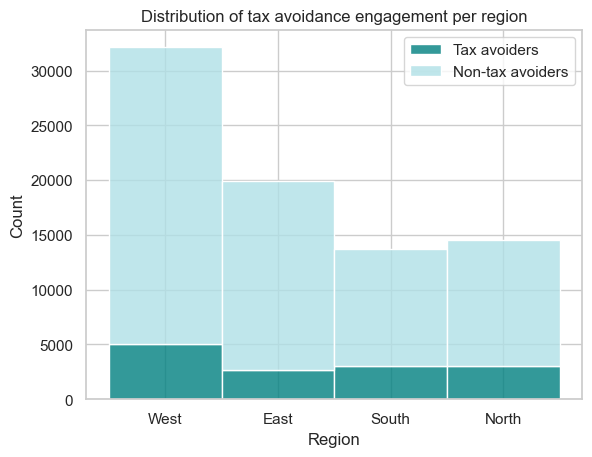

In [67]:
# Creating a barplot of tax avoidance per region
sns.set_theme(style="whitegrid")
sns.histplot(data=df_eda, x='region', hue='tax_avoidance', multiple="stack",
             alpha=0.8, palette=colour_palette_list, binwidth=1, discrete=True)
plt.title('Distribution of tax avoidance engagement per region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(loc='upper right', labels=['Tax avoiders', 'Non-tax avoiders'])
plt.show()

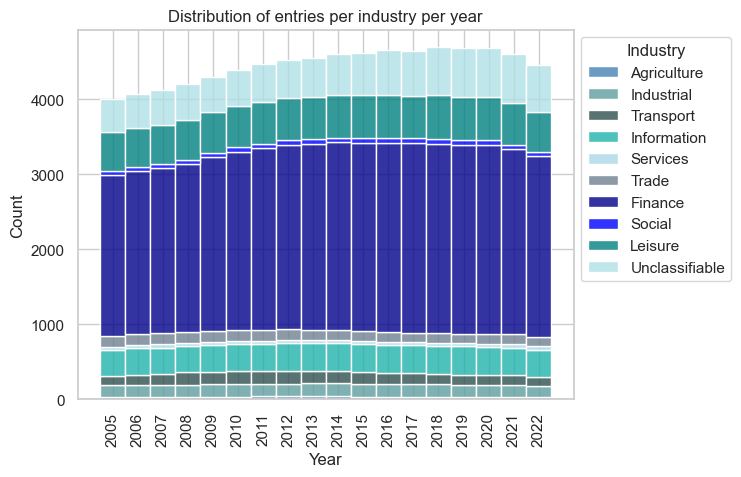

In [68]:
# Creating a barplot of entries per industry per year
labels = ['Agriculture', 'Industrial', 'Transport', 'Information', 'Services',
          'Trade', 'Finance', 'Social', 'Leisure', 'Unclassifiable'
]

sns.set_theme(style="whitegrid")
sns.histplot(data=df_eda, x='fyear', hue='industry', multiple="stack",
             alpha=0.8, palette=colour_palette_list, binwidth=1, discrete=True)
plt.title('Distribution of entries per industry per year')
plt.xlabel('Year')
plt.ylabel('Count')
years = np.arange(2005, 2023)
plt.xticks(ticks=years, labels=years, rotation=90)
plt.legend(title='Industry', labels=labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

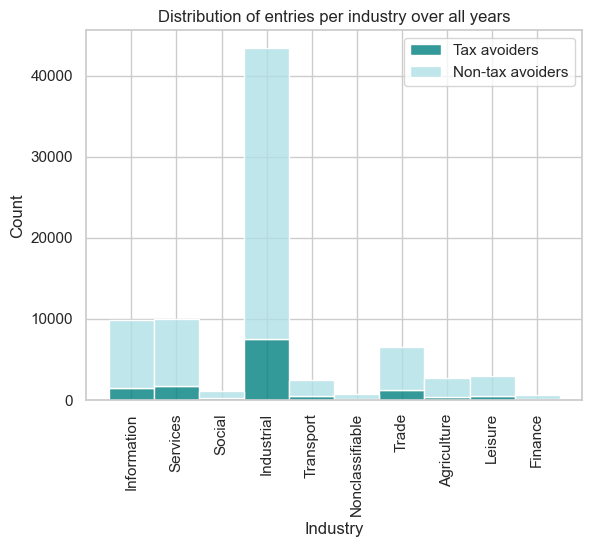

In [69]:
# Creating a barplot of tax avoidance per industry
sns.set_theme(style="whitegrid")
sns.histplot(data=df_eda, x='industry', hue='tax_avoidance',
             multiple="stack", alpha=0.8, palette=colour_palette_list)
plt.title('Distribution of entries per industry over all years')
plt.xlabel('Industry')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(loc='upper right', labels=['Tax avoiders', 'Non-tax avoiders'])
plt.show()

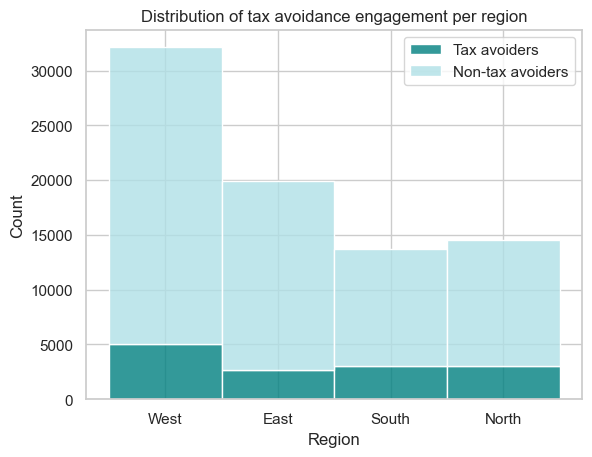

In [70]:
# Creating a barplot of tax avoidance per region
sns.set_theme(style="whitegrid")
sns.histplot(data=df_eda, x='region', hue='tax_avoidance', multiple="stack",
             alpha=0.8, palette=colour_palette_list, binwidth=1, discrete=True)
plt.title('Distribution of tax avoidance engagement per region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(loc='upper right', labels=['Tax avoiders', 'Non-tax avoiders'])
plt.show()

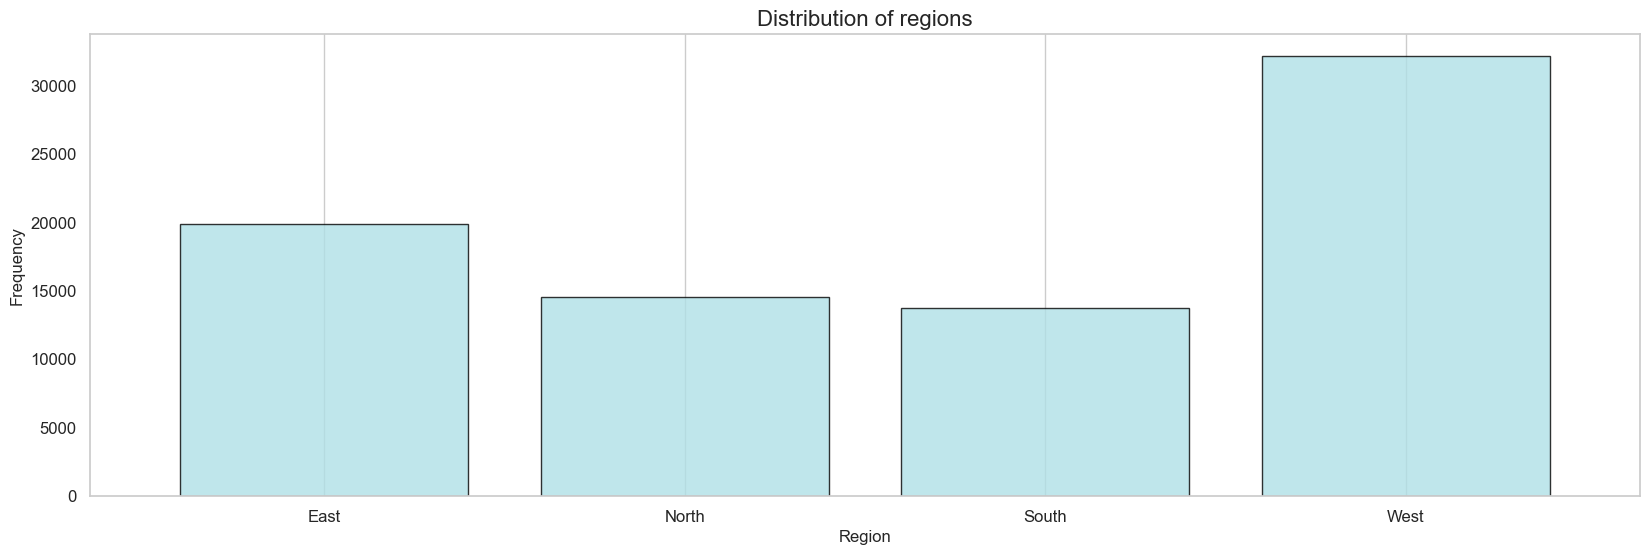

In [71]:
# Extracting the fiscal year variable from the data
region_col = df_eda['region']

# Counting frequency of each year
region_counts = region_col.value_counts().sort_index()

# Creating a barplot of entries per industry
plt.figure(figsize=(20, 6))
region_counts.plot(kind='bar', alpha=0.8, color=colour_palette_list[0],
                 edgecolor='black', width=0.8)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y')
plt.title('Distribution of regions', fontsize=16)

plt.show()

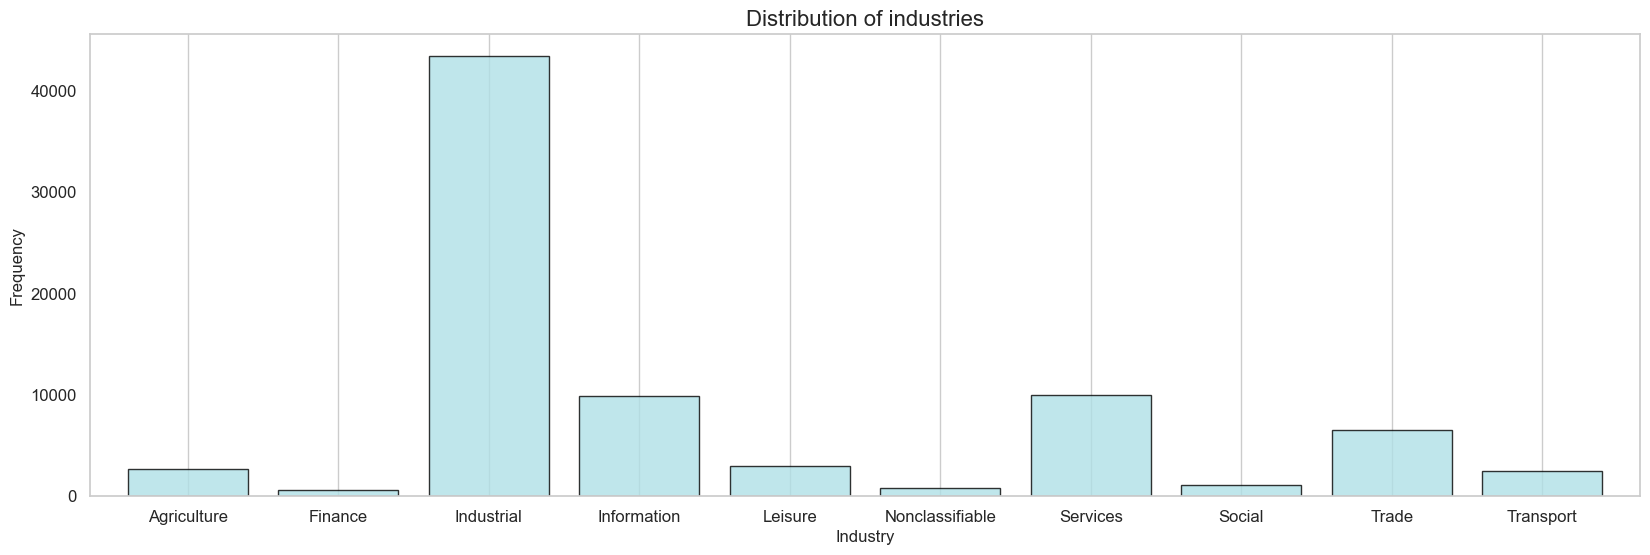

In [72]:
# Extracting the fiscal year variable from the data
industry_col = df_eda['industry']

# Counting frequency of each year
industry_counts = industry_col.value_counts().sort_index()

# Creating a barplot of entries per industry
plt.figure(figsize=(20, 6))
industry_counts.plot(kind='bar', alpha=0.8, color=colour_palette_list[0],
                 edgecolor='black', width=0.8)
plt.xlabel('Industry', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y')
plt.title('Distribution of industries', fontsize=16)

plt.show()

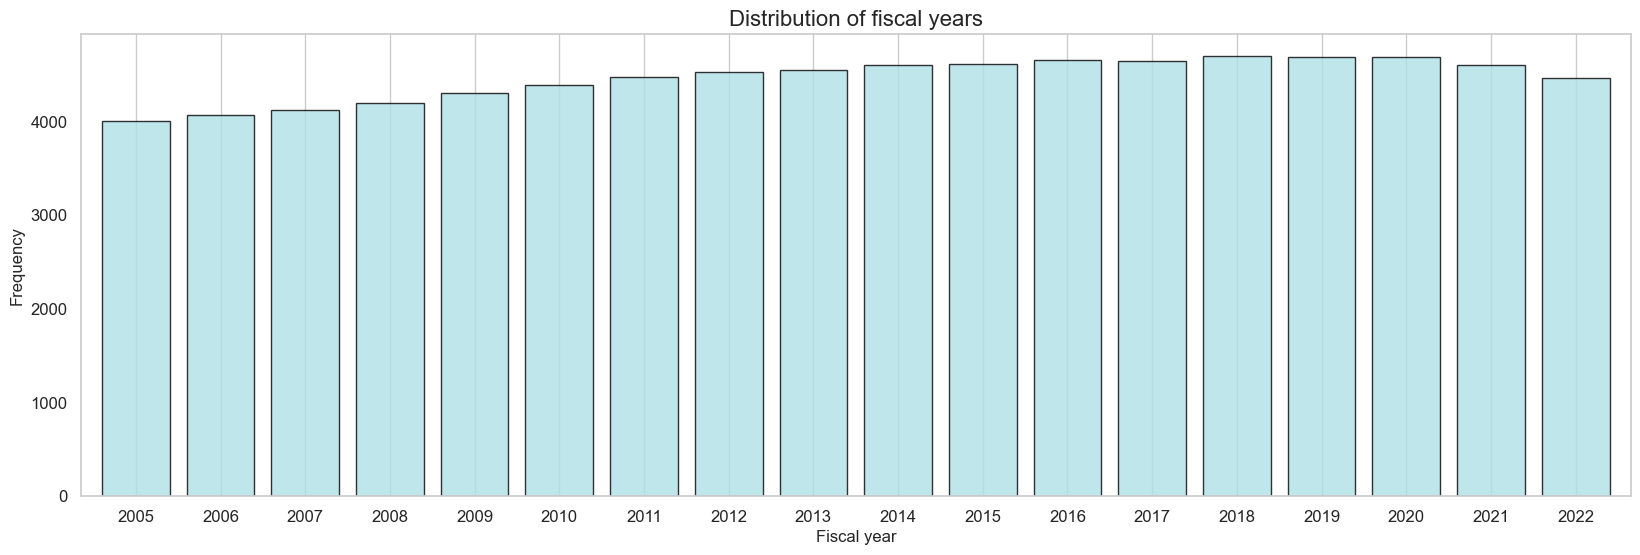

In [73]:
# Extracting the fiscal year variable from the data
fyear_col = df_eda['fyear']

# Counting frequency of each year
year_counts = fyear_col.value_counts().sort_index()

# Creating a barplot of entries per year
plt.figure(figsize=(20, 6))
year_counts.plot(kind='bar', alpha=0.8, color=colour_palette_list[0],
                 edgecolor='black', width=0.8)
plt.xlabel('Fiscal year', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y')
plt.title('Distribution of fiscal years', fontsize=16)

plt.show()

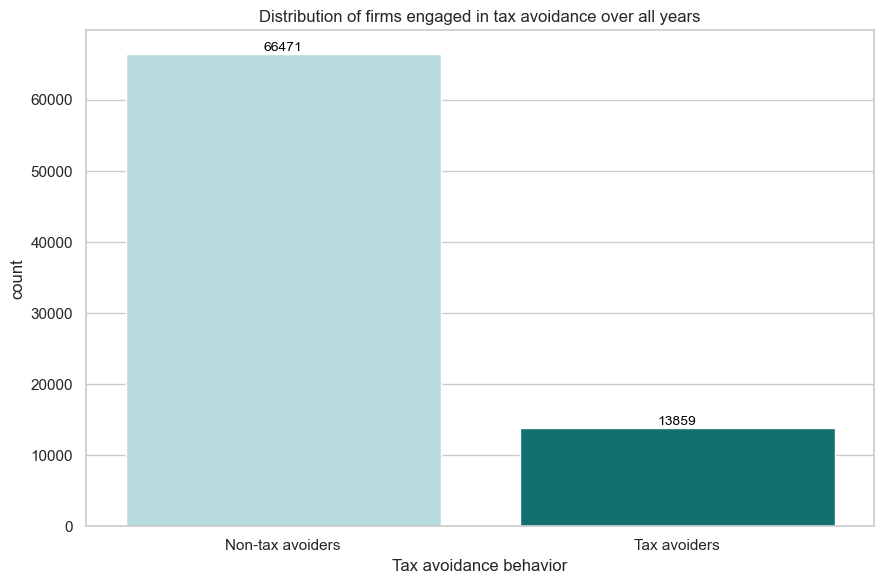

In [74]:
# Showing engagement in tax avoidance over all years
tax_avoidance = {
    0: 'Tax avoiders',
    1: 'Non-tax avoiders'
}

plt.figure(figsize=(9, 6))
ax = sns.countplot(data=df_eda, x='tax_avoidance', palette=[color_codes[i] for i in range(2)])
plt.title('Distribution of firms engaged in tax avoidance over all years')
plt.xlabel('Tax avoidance behavior')
plt.xticks(ticks=[0, 1], labels=['Non-tax avoiders', 'Tax avoiders']) 

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height() + 0.5, '%d' % int(p.get_height()),
            fontsize=10, color='black', ha='center', va='bottom')

plt.tight_layout()
plt.show()

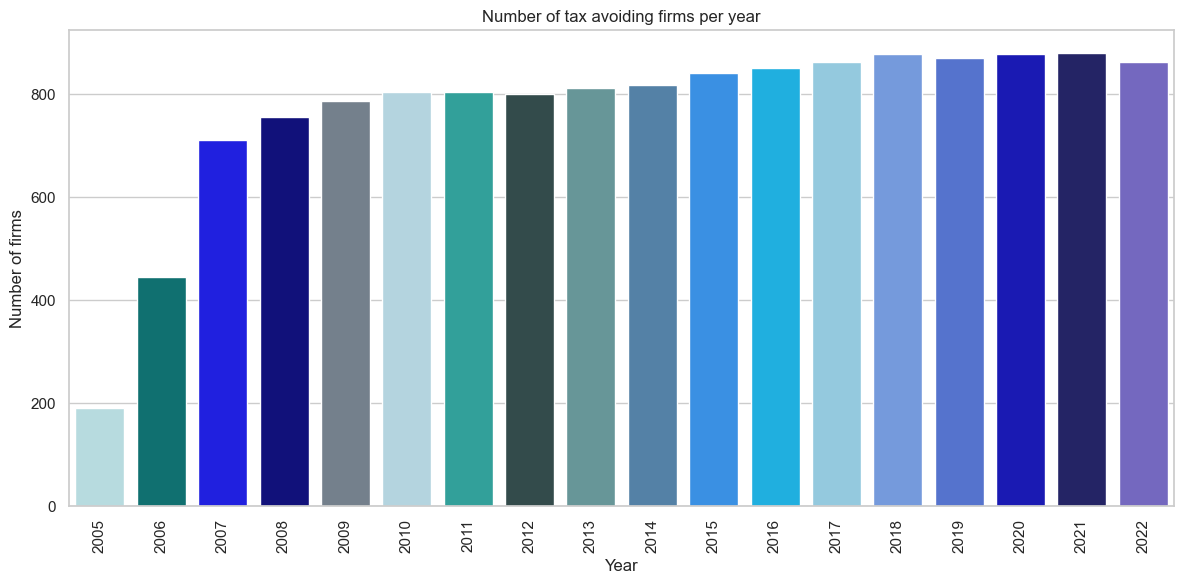

In [75]:
tax_by_year = df_eda.groupby('fyear')['tax_avoidance'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=tax_by_year, x='fyear', y='tax_avoidance', palette=color_codes)
plt.title('Number of tax avoiding firms per year')
plt.xlabel('Year')
plt.ylabel('Number of firms')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

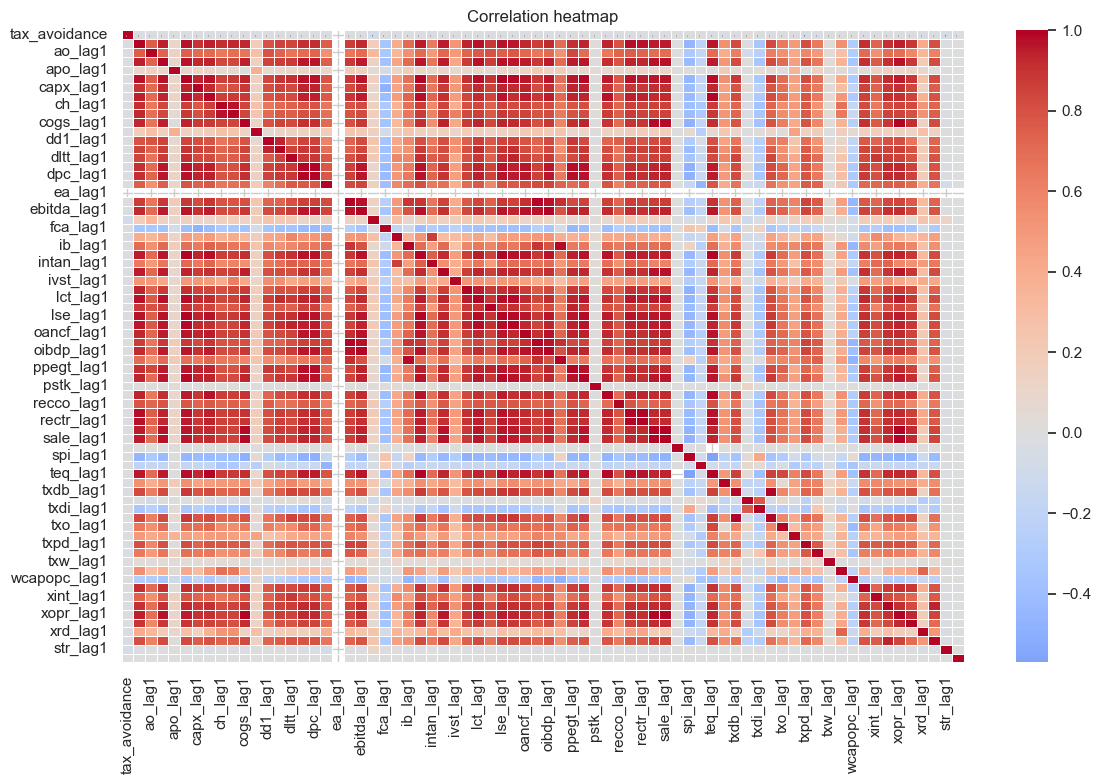

In [76]:
# Displaying the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, annot_kws={'rotation':90, 'size': 0}, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)

plt.title("Correlation heatmap")
plt.tight_layout()
plt.show()

## Data cleaning and preprocessing

### Filtering the features

In [77]:
# Renaming the dataset
df_dc = df_lagged

In [78]:
df_dc.shape

(80330, 94)

In [79]:
# Removing all variables that have no variance
for column in df_dc.columns:
    nunique_values = df_dc[column].nunique()
    if nunique_values == 1:
        print(f"Column '{column}' has only one unique value and will be dropped.")
        df_dc = df_dc.drop(column, axis=1)
    else:
        pass

Column 'indfmt' has only one unique value and will be dropped.
Column 'datafmt' has only one unique value and will be dropped.
Column 'consol' has only one unique value and will be dropped.
Column 'popsrc' has only one unique value and will be dropped.
Column 'ea_lag1' has only one unique value and will be dropped.


In [80]:
# Selecting only companies with a fiscal year end in December
df_dc = df_dc[df_dc['fyr']=='12']

In [81]:
df_dc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72699 entries, 75058 to 60069
Data columns (total 89 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gvkey          72699 non-null  object 
 1   acctstd        72641 non-null  object 
 2   curcd          72699 non-null  object 
 3   fyear          72699 non-null  object 
 4   fyr            72699 non-null  object 
 5   pddur          72699 non-null  object 
 6   datadate       72699 non-null  object 
 7   conm           72699 non-null  object 
 8   costat         72699 non-null  object 
 9   fic            72699 non-null  object 
 10  city           72560 non-null  object 
 11  conml          72699 non-null  object 
 12  naics          72699 non-null  object 
 13  sic            72699 non-null  object 
 14  region         72699 non-null  object 
 15  id_cat         72699 non-null  object 
 16  id_num         72699 non-null  object 
 17  industry       72699 non-null  object 
 18  tax_avo

In [82]:
# Removing categorical variables that give no information
df_dc = df_dc.drop(columns=['gvkey', 'curcd', 'pddur', 'datadate', 'fyr',
                            'costat', 'fic', 'conml', 'naics', 'sic'])

In [83]:
df_dc.shape

(72699, 79)

### Handling duplicates

In [84]:
# Checking for duplicates in the dataset
print('Number of duplicates in dataset: ', len(df_dc[df_dc.duplicated()]))

Number of duplicates in dataset:  0


### Handling outliers

In [85]:
# Code inspired by:
# https://www.digitalocean.com/community/tutorials/anomaly-detection-isolation-forest
# https://www.geeksforgeeks.org/anomaly-detection-using-isolation-forest/

# Splitting the numerical and categorical variables
df_dc['id_num'] = df_dc['id_num'].astype(int)
df_num = df_dc.select_dtypes(include='number')
df_cat = df_dc.select_dtypes(exclude='number')

In [86]:
# Renaming the dataset
df_out = df_num

In [87]:
# Creation isolationforest
isf = IsolationForest(contamination=0.01, random_state=123)
isf.fit(df_out)

IsolationForest(contamination=0.01, random_state=123)

In [88]:
# Extract scores and predictions
isf_scores = isf.decision_function(df_out)
isf_outliers = isf.predict(df_out)

In [89]:
# Converting to numpy
df_out = df_out.to_numpy()

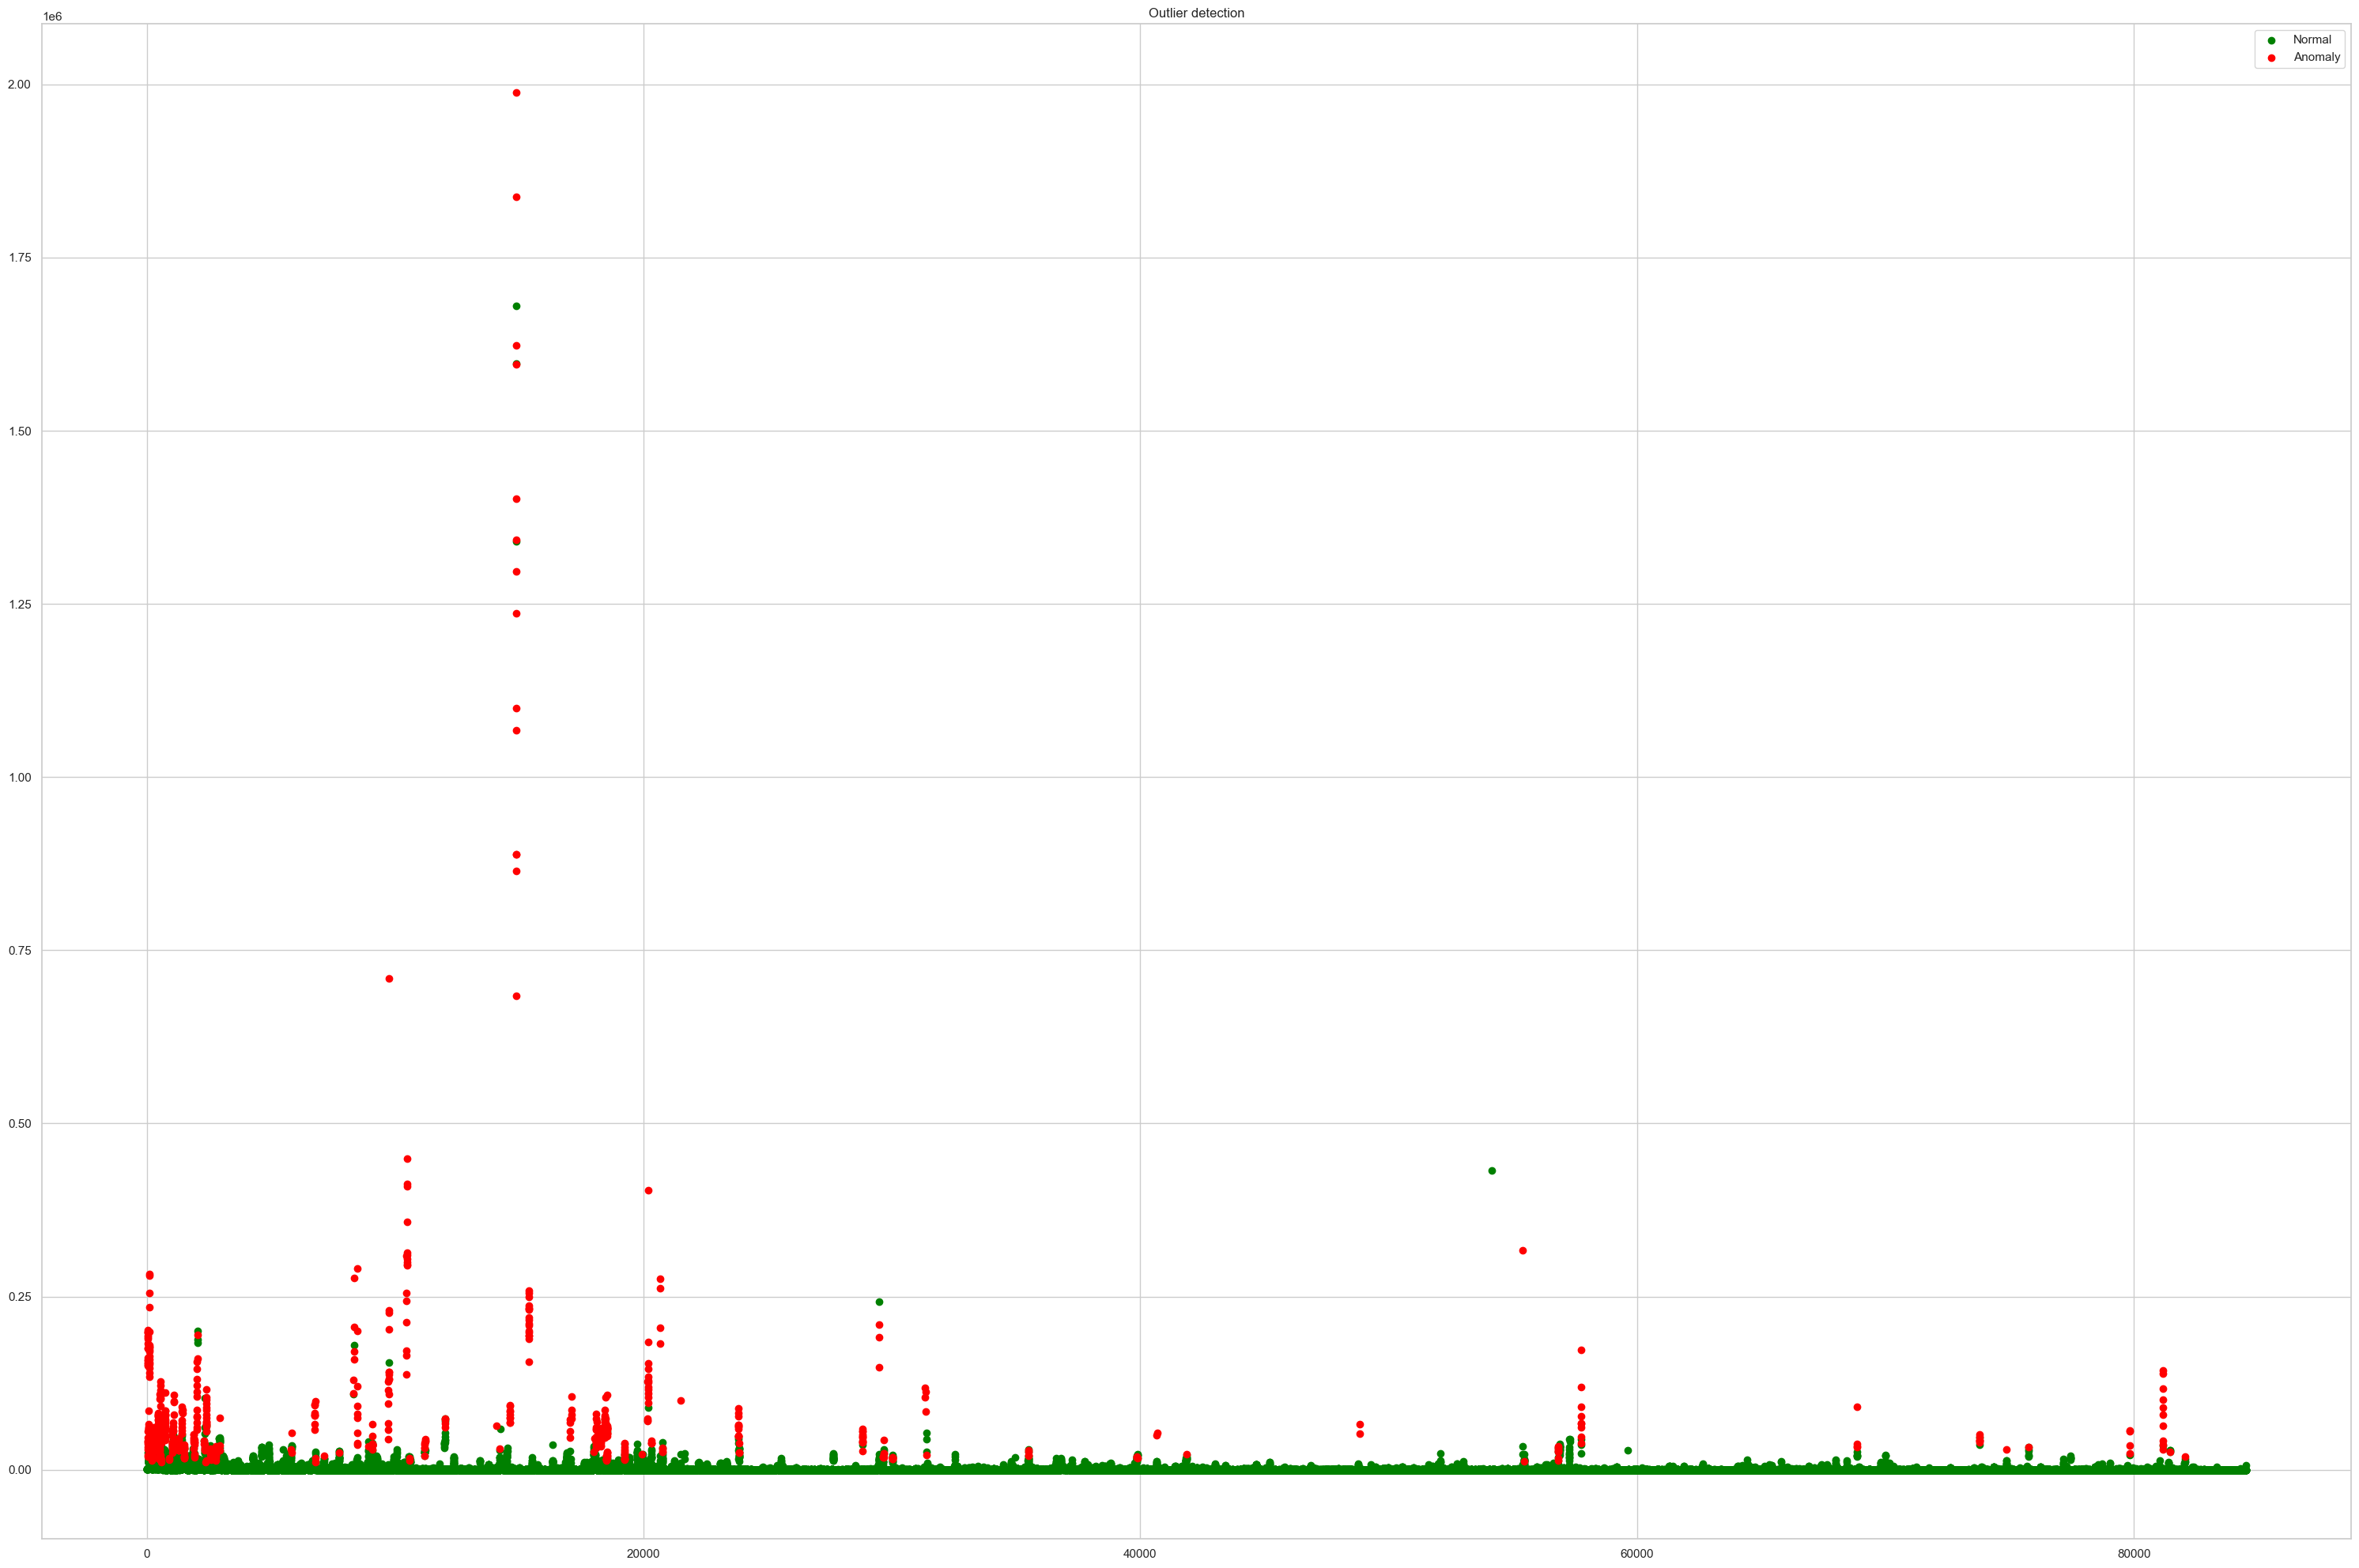

In [90]:
# Visualizing the outliers
def plot_training_data(X, y, title):
    plt.figure(figsize=(30, 20))

    # Plot normal points
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color='green', label='Normal', marker='o')
    # Plot anomalies
    plt.scatter(X[y == -1, 0], X[y == -1, 1], color='red', label='Anomaly', marker='o')

    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_data(df_out, isf_outliers, 'Outlier detection')

In [91]:
# Describing the dataframe
df_num['iso_forest_outliers'] = isf.predict(df_num)
df_num.describe()

,id_num,act_lag1,ao_lag1,ap_lag1,apo_lag1,at_lag1,capx_lag1,ceq_lag1,ch_lag1,che_lag1,cogs_lag1,dc_lag1,dd1_lag1,dlc_lag1,dltt_lag1,dp_lag1,dpc_lag1,dvt_lag1,ebit_lag1,ebitda_lag1,emp_lag1,fca_lag1,gdwl_lag1,ib_lag1,icapt_lag1,intan_lag1,invt_lag1,ivst_lag1,lco_lag1,lct_lag1,lo_lag1,lse_lag1,lt_lag1,oancf_lag1,oiadp_lag1,oibdp_lag1,pi_lag1,ppegt_lag1,ppent_lag1,pstk_lag1,re_lag1,recco_lag1,rect_lag1,rectr_lag1,revt_lag1,sale_lag1,sco_lag1,spi_lag1,sppiv_lag1,teq_lag1,txc_lag1,txdb_lag1,txdc_lag1,txdi_lag1,txditc_lag1,txo_lag1,txp_lag1,txpd_lag1,txt_lag1,txw_lag1,wcap_lag1,wcapopc_lag1,xacc_lag1,xint_lag1,xlr_lag1,xopr_lag1,xpp_lag1,xrd_lag1,xsga_lag1,str_lag1,etr_lag1,iso_forest_outliers
count,72699.000000,6.634900e+04,66312.000000,66330.000000,66263.000000,6.635000e+04,56396.000000,6.634300e+04,64584.000000,66340.000000,6.628300e+04,66273.000000,55068.000000,66292.000000,66302.000000,64062.000000,59860.000000,16132.000000,66010.000000,6.602200e+04,35805.000000,66268.000000,66272.000000,66366.000000,6.634700e+04,65641.000000,66308.000000,64531.000000,65912.000000,6.634600e+04,66316.000000,6.635000e+04,6.635000e+04,61174.000000,66010.000000,6.602200e+04,66366.000000,6.045600e+04,6.633200e+04,66250.000000,6.634200e+04,66321.000000,66339.000000,66330.000000,6.635300e+04,6.635300e+04,6.624800e+04,46164.000000,34610.000000,4.832000e+04,66269.000000,66272.000000,10915.000000,66269.000000,66272.000000,66264.000000,66307.000000,38032.000000,66309.000000,66263.000000,66345.000000,57265.000000,66304.000000,62853.000000,42035.000000,6.603400e+04,66287.000000,21523.000000,66275.000000,66503.000000,3.789600e+04,72699.000
mean,42297.746833,1.921040e+03,300.915385,541.559691,4.541484,5.636131e+03,379.445220,2.122997e+03,402.549107,504.896385,2.894384e+03,25.600384,226.330659,387.706110,1087.168588,282.930566,316.809754,274.428903,384.918039,6.593602e+02,9.032328,-7.605372,553.698724,223.000584,3.403324e+03,984.895851,452.230486,115.234140,683.986841,1.608262e+03,489.925004,5.636131e+03,3.319378e+03,584.752488,384.918039,6.593602e+02,304.950933,4.521809e+03,2.142026e+03,0.371002,1.370022e+03,135.553769,792.292986,656.865112,4.345268e+03,4.345268e+03,1.509480e-08,-53.819754,-25.312988,2.433618e+03,51.945785,135.248353,-6.204613,-6.515115,135.248353,17.085935,32.107995,127.598093,73.232951,13.390525,312.869103,-26.565338,285.046847,69.141179,433.702625,3.706976e+03,39.629577,214.692400,528.633221,25.496860,5.812171e+01,0.980
std,24314.202780,2.454431e+04,3433.099980,8488.872765,210.494408,7.727199e+04,6663.519051,3.084361e+04,5508.702705,6363.572772,5.542381e+04,462.952766,4451.559058,5598.804713,13234.285360,5326.478534,5530.471976,2005.520743,5573.994781,1.044248e+04,33.200578,635.327184,4902.384002,4264.607921,4.778029e+04,9717.501450,7369.404998,1813.009568,8873.373988,2.181660e+04,7851.550754,7.727199e+04,4.244194e+04,9800.498804,5573.994781,1.044248e+04,5112.247078,1.022499e+05,4.058500e+04,33.245761,2.647782e+04,1502.465693,9646.764463,8507.181371,7.463868e+04,7.463868e+04,3.885202e-06,2216.319702,831.111337,3.925573e+04,623.076610,1653.349103,165.775842,473.479252,1653.349103,529.908105,527.895560,1217.050082,930.811874,495.434811,6129.026000,2239.718226,3768.271824,889.339289,5530.994465,6.514905e+04,1185.788019,1737.810497,5829.194531,7.157556,7.784357e+03,0.199
min,0.000000,-1.203000e+00,-41.257000,-0.217000,0.000000,0.000000e+00,0.000000,-7.814000e+03,-7.085000,-7.085000,-2.595790e+02,-140.000000,-9.558000,-3.300000,0.000000,-116.183000,-116.183000,0.000000,-23783.000000,-1.360900e+04,0.001000,-86576.000000,0.000000,-256554.000000,-6.500376e+03,-38.210000,-2.106000,-3.240000,-519.854000,-2.900000e-01,-438.632000,0.000000e+00,-1.024800e+01,-20269.881000,-23783.000000,-1.360900e+04,-303099.000000,0.000000e+00,0.000000e+00,0.000000,-3.685900e+04,-78.518000,-77.317000,-0.132000,-1.329700e+04,-1.329700e+04,0.000000e+00,-338212.000000,-87440.000000,-7.798000e+03,-14952.000000,-12.000000,-6538.000000,-70883.000000,-12.000000,-2214.000000,-

In [92]:
# Checking the outliers
anomaly = df_num.loc[df_num['iso_forest_outliers']==-1]
anomaly_index = list(anomaly.index)
print(anomaly)

       id_num    act_lag1    ao_lag1     ap_lag1  apo_lag1      at_lag1  \
55386   55386  316431.659   1089.502   23251.567       0.0   499936.398   
6766     6766   81518.000   3631.000   27161.000    9363.0   284846.000   
6767     6767   92663.000   9020.000   28674.000    9828.0   313695.000   
6768     6768   94015.000   6031.000   31531.000       0.0   327519.000   
6769     6769   65405.000   7020.000   30035.000       0.0   343110.000   
...       ...         ...        ...         ...       ...          ...   
8332     8332  130076.000  14344.000  131180.000       0.0   473485.000   
8333     8333  159273.000  18339.000  130766.000       0.0   565258.000   
8334     8334  170840.000  19201.000  154873.000       0.0   610799.000   
8336     8336  206284.000  28080.000  170909.000       0.0  1173229.000   
8337     8337  276478.000  31717.000  212949.000       0.0  1286748.000   

       capx_lag1    ceq_lag1     ch_lag1    che_lag1    cogs_lag1  dc_lag1  \
55386   1258.047   15

In [93]:
# Removing the outliers
df_num = df_num[df_num['iso_forest_outliers']!=-1]

In [94]:
# Removing the iso_forest_outliers column
df_num = df_num.drop(columns=['iso_forest_outliers'])

### Handling missing values

In [95]:
# Checking for missing values
percent_missing = round(df_dc.isnull().sum() * 100 / len(df_dc), 2)
df_missing = pd.DataFrame({'Missing (%)': percent_missing})
print(df_missing.sort_values(['Missing (%)'], ascending=[False]))

               Missing (%)
txdc_lag1            84.99
dvt_lag1             77.81
xrd_lag1             70.39
sppiv_lag1           52.39
emp_lag1             50.75
...                    ...
region                0.00
industry              0.00
conm                  0.00
fyear                 0.00
tax_avoidance         0.00

[79 rows x 1 columns]


In [96]:
# Checking dataset after removing missing values
df_drop = df_dc.dropna()
print('Shape after deleting missing values: ', df_drop.shape)

Shape after deleting missing values:  (399, 79)


In [97]:
# # Visualizing the number of data in each column
# msno.bar(df_dc, figsize=(15,15), fontsize=12, sort="ascending")

In [98]:
# # Visualizing the missing data patterns
# msno.matrix(df_dc,figsize=(15,15), fontsize=12)

In [99]:
# # Measuring of the missing data relationship
# msno.dendrogram(df_dc)

#### Handling missing values for categorical features

In [100]:
# Checking missing values for categorical variables
percent_missing = round(df_cat.isnull().sum() * 100 / len(df_cat), 2)
df_cat_missing = pd.DataFrame({'Missing (%)': percent_missing})
print(df_cat_missing.sort_values(['Missing (%)'], ascending=[False]))

               Missing (%)
city                  0.19
acctstd               0.08
fyear                 0.00
conm                  0.00
region                0.00
id_cat                0.00
industry              0.00
tax_avoidance         0.00


In [101]:
# Removing the categorical variables with missing values
df_cat_missing = df_cat_missing.loc[df_cat_missing['Missing (%)'] > 0]
df_cat_drop = df_cat.drop(columns=df_cat_missing.index.tolist())
df_cat_drop.head()

,fyear,conm,region,id_cat,industry,tax_avoidance
75058,2016,1&1 AG,West,75058,Information,True
75059,2017,1&1 AG,West,75059,Information,True
75060,2018,1&1 AG,West,75060,Information,True
75061,2019,1&1 AG,West,75061,Information,False
75062,2020,1&1 AG,West,75062,Information,False


In [102]:
# Checking the dataset
df_cat_drop.shape

(72699, 6)

#### Checking and partially handling missing values for numerical features

In [103]:
# Checking missing values for numerical variables
percent_missing = round(df_num.isnull().sum() * 100 / len(df_num), 2)
df_num_missing = pd.DataFrame({'Missing (%)': percent_missing})
print(df_num_missing.sort_values(['Missing (%)'], ascending=[False]))

            Missing (%)
txdc_lag1         85.09
dvt_lag1          78.23
xrd_lag1          70.89
sppiv_lag1        52.74
emp_lag1          51.20
...                 ...
lse_lag1           8.82
pi_lag1            8.80
ib_lag1            8.80
str_lag1           8.61
id_num             0.00

[71 rows x 1 columns]


In [104]:
# Checking which variables have more than 40% missing values
df_num_missing_40plus = df_num_missing.loc[df_num_missing['Missing (%)'] >= 40]
print(df_num_missing_40plus)

            Missing (%)
dvt_lag1          78.23
emp_lag1          51.20
sppiv_lag1        52.74
txdc_lag1         85.09
txpd_lag1         48.09
xlr_lag1          42.28
xrd_lag1          70.89
etr_lag1          48.28


In [105]:
# Removing all rows missing 'etr_lag1'
df_num_etr = df_num.dropna(subset=['etr_lag1'])
print('Shape after deleting missing etr_lag1: ', df_num_etr.shape)

Shape after deleting missing etr_lag1:  (37224, 71)


In [106]:
# Re-checking missing values for numerical variables
percent_missing = round(df_num_etr.isnull().sum() * 100 / len(df_num_etr), 2)
df_num_missing = pd.DataFrame({'Missing (%)': percent_missing})
print(df_num_missing.sort_values(['Missing (%)'], ascending=[False]))

            Missing (%)
txdc_lag1         84.52
dvt_lag1          67.83
xrd_lag1          59.46
sppiv_lag1        38.83
xlr_lag1          37.30
...                 ...
ppent_lag1         0.00
recco_lag1         0.00
rect_lag1          0.00
rectr_lag1         0.00
etr_lag1           0.00

[71 rows x 1 columns]


In [107]:
# Checking which variables have more than 10% missing values
df_num_missing_10plus = df_num_missing.loc[df_num_missing['Missing (%)'] > 10]
print(df_num_missing_10plus)

            Missing (%)
dd1_lag1          17.40
dvt_lag1          67.83
emp_lag1          33.20
spi_lag1          22.01
sppiv_lag1        38.83
teq_lag1          22.15
txdc_lag1         84.52
xlr_lag1          37.30
xrd_lag1          59.46


In [108]:
# Dropping all variables with 10% or more missing values
df_num_drop = df_num_etr.drop(columns=df_num_missing_10plus.index.tolist())
df_num_drop.head()

,id_num,act_lag1,ao_lag1,ap_lag1,apo_lag1,at_lag1,capx_lag1,ceq_lag1,ch_lag1,che_lag1,cogs_lag1,dc_lag1,dlc_lag1,dltt_lag1,dp_lag1,dpc_lag1,ebit_lag1,ebitda_lag1,fca_lag1,gdwl_lag1,ib_lag1,icapt_lag1,intan_lag1,invt_lag1,ivst_lag1,lco_lag1,lct_lag1,lo_lag1,lse_lag1,lt_lag1,oancf_lag1,oiadp_lag1,oibdp_lag1,pi_lag1,ppegt_lag1,ppent_lag1,pstk_lag1,re_lag1,recco_lag1,rect_lag1,rectr_lag1,revt_lag1,sale_lag1,sco_lag1,txc_lag1,txdb_lag1,txdi_lag1,txditc_lag1,txo_lag1,txp_lag1,txpd_lag1,txt_lag1,txw_lag1,wcap_lag1,wcapopc_lag1,xacc_lag1,xint_lag1,xopr_lag1,xpp_lag1,xsga_lag1,str_lag1,etr_lag1
75059,75059,263.535,300.257,890.290,0.0,1843.259,26.919,-452.260,4.562,4.562,1690.066,122.248,16.333,1086.819,8.610,8.610,379.224,387.834,0.083,506.482,203.610,674.000,749.655,39.286,0.000,140.106,1046.729,79.340,1843.259,2256.078,210.826,379.224,387.834,354.580,771.478,528.915,0.0,615.289,14.479,170.810,156.331,2430.058,2430.058,0.0,116.166,43.190,-4.481,43.190,0.0,14.692,0.546,111.685,0.0,-783.194,-88.999,106.038,24.815,2042.224,1.215,355.865,29.8,0.143978
75060,75060,656.553,228.519,451.410,0.0,4735.708,15.556,3805.080,149.681,151.504,1823.607,79.414,3.606,0.267,64.088,64.088,439.036,503.124,0.260,2932.943,293.748,3805.347,3834.357,46.467,1.823,220.227,675.243,9.612,4735.708,930.628,347.610,439.036,503.124,431.330,25.255,14.356,0.0,1163.554,249.142,442.126,192.984,2812.313,2812.313,0.0,140.261,245.506,-19.302,245.506,0.0,50.306,0.188,120.959,0.0,-18.690,-102.022,102.422,8.724,2309.189,0.000,468.135,29.9,0.042821
75061,75061,1064.584,487.047,494.535,0.0,5246.640,15.489,4280.075,3.968,6.851,2400.966,320.525,0.267,0.000,154.696,154.696,565.023,719.719,0.218,2932.943,406.032,4280.075,3679.759,89.548,2.883,152.122,646.924,71.761,5246.640,966.565,155.552,565.023,719.719,562.575,24.525,13.842,0.0,1653.248,76.776,763.804,687.028,3662.460,3662.460,0.0,168.922,247.880,-12.379,247.880,0.0,37.985,6.032,156.543,0.0,417.660,-383.347,93.221,4.651,2942.741,0.000,503.932,29.9,1.067567
75062,75062,1309.225,473.268,345.663,0.0,6461.944,20.452,4640.846,31.785,32.480,2342.091,293.828,7.573,40.215,155.014,155.014,808.999,964.013,0.414,2932.943,373.620,4681.061,4615.755,79.227,0.695,195.659,548.895,1002.240,6461.944,1821.098,375.707,808.999,964.013,522.436,82.275,62.018,0.0,2018.055,27.893,969.594,941.701,3674.846,3674.846,0.0,166.834,229.748,-18.018,229.748,0.0,26.713,33.253,148.816,0.0,760.330,-121.314,92.627,0.652,2710.833,0.000,315.267,29.9,4.110388
75063,75063,1553.297,347.848,375.666,0.0,6690.337,207.245,4853.760,4.360,5.578,2535.771,142.665,12.477,85.702,155.395,155.395,711.584,866.979,0.285,2932.943,219.593,4939.462,4662.455,85.366,1.218,186.417,574.560,942.310,6690.337,1836.577,450.672,711.584,866.979,312.587,157.353,124.745,0.0,2228.835,65.809,1264.924,1199.115,3786.788,3786.788,0.0,88.730,234.005,4.264,234.005,0.0,28.292,23.445,92.994,0.0,978.737,-62.051,80.240,1.493,2919.809,0.000,337.125,29.8,3.294762


In [109]:
# Checking which variables have up to 10% missing values
df_num_missing_10minus = df_num_missing.loc[(df_num_missing['Missing (%)'] > 0) &  (df_num_missing['Missing (%)'] <= 10)]
print(df_num_missing_10minus)

              Missing (%)
apo_lag1             0.02
capx_lag1            3.16
ch_lag1              2.00
dc_lag1              0.02
dlc_lag1             0.01
dltt_lag1            0.01
dp_lag1              1.16
dpc_lag1             0.54
fca_lag1             0.01
gdwl_lag1            0.01
intan_lag1           0.57
invt_lag1            0.01
ivst_lag1            2.01
lco_lag1             0.05
ppegt_lag1           5.20
pstk_lag1            0.02
re_lag1              0.01
sco_lag1             0.02
txc_lag1             0.01
txdb_lag1            0.01
txdi_lag1            0.01
txditc_lag1          0.01
txo_lag1             0.01
txw_lag1             0.02
wcapopc_lag1         6.93
xint_lag1            2.51
xpp_lag1             0.01


In [110]:
# Preparing for merging the datasets
df_cat_drop['id_comb'] = df_cat_drop['id_cat'].astype(int)
df_num_drop['id_comb'] = df_num_drop['id_num'].astype(int)

In [111]:
# Merging the numerical and non-numerical variables
df_comb2 = pd.merge(left=df_num_drop, right=df_cat_drop, on='id_comb', how='left')
df_comb2.head()

,id_num,act_lag1,ao_lag1,ap_lag1,apo_lag1,at_lag1,capx_lag1,ceq_lag1,ch_lag1,che_lag1,cogs_lag1,dc_lag1,dlc_lag1,dltt_lag1,dp_lag1,dpc_lag1,ebit_lag1,ebitda_lag1,fca_lag1,gdwl_lag1,ib_lag1,icapt_lag1,intan_lag1,invt_lag1,ivst_lag1,lco_lag1,lct_lag1,lo_lag1,lse_lag1,lt_lag1,oancf_lag1,oiadp_lag1,oibdp_lag1,pi_lag1,ppegt_lag1,ppent_lag1,pstk_lag1,re_lag1,recco_lag1,rect_lag1,rectr_lag1,revt_lag1,sale_lag1,sco_lag1,txc_lag1,txdb_lag1,txdi_lag1,txditc_lag1,txo_lag1,txp_lag1,txpd_lag1,txt_lag1,txw_lag1,wcap_lag1,wcapopc_lag1,xacc_lag1,xint_lag1,xopr_lag1,xpp_lag1,xsga_lag1,str_lag1,etr_lag1,id_comb,fyear,conm,region,id_cat,industry,tax_avoidance
0,75059,263.535,300.257,890.290,0.0,1843.259,26.919,-452.260,4.562,4.562,1690.066,122.248,16.333,1086.819,8.610,8.610,379.224,387.834,0.083,506.482,203.610,674.000,749.655,39.286,0.000,140.106,1046.729,79.340,1843.259,2256.078,210.826,379.224,387.834,354.580,771.478,528.915,0.0,615.289,14.479,170.810,156.331,2430.058,2430.058,0.0,116.166,43.190,-4.481,43.190,0.0,14.692,0.546,111.685,0.0,-783.194,-88.999,106.038,24.815,2042.224,1.215,355.865,29.8,0.143978,75059,2017,1&1 AG,West,75059,Information,True
1,75060,656.553,228.519,451.410,0.0,4735.708,15.556,3805.080,149.681,151.504,1823.607,79.414,3.606,0.267,64.088,64.088,439.036,503.124,0.260,2932.943,293.748,3805.347,3834.357,46.467,1.823,220.227,675.243,9.612,4735.708,930.628,347.610,439.036,503.124,431.330,25.255,14.356,0.0,1163.554,249.142,442.126,192.984,2812.313,2812.313,0.0,140.261,245.506,-19.302,245.506,0.0,50.306,0.188,120.959,0.0,-18.690,-102.022,102.422,8.724,2309.189,0.000,468.135,29.9,0.042821,75060,2018,1&1 AG,West,75060,Information,True
2,75061,1064.584,487.047,494.535,0.0,5246.640,15.489,4280.075,3.968,6.851,2400.966,320.525,0.267,0.000,154.696,154.696,565.023,719.719,0.218,2932.943,406.032,4280.075,3679.759,89.548,2.883,152.122,646.924,71.761,5246.640,966.565,155.552,565.023,719.719,562.575,24.525,13.842,0.0,1653.248,76.776,763.804,687.028,3662.460,3662.460,0.0,168.922,247.880,-12.379,247.880,0.0,37.985,6.032,156.543,0.0,417.660,-383.347,93.221,4.651,2942.741,0.000,503.932,29.9,1.067567,75061,2019,1&1 AG,West,75061,Information,False
3,75062,1309.225,473.268,345.663,0.0,6461.944,20.452,4640.846,31.785,32.480,2342.091,293.828,7.573,40.215,155.014,155.014,808.999,964.013,0.414,2932.943,373.620,4681.061,4615.755,79.227,0.695,195.659,548.895,1002.240,6461.944,1821.098,375.707,808.999,964.013,522.436,82.275,62.018,0.0,2018.055,27.893,969.594,941.701,3674.846,3674.846,0.0,166.834,229.748,-18.018,229.748,0.0,26.713,33.253,148.816,0.0,760.330,-121.314,92.627,0.652,2710.833,0.000,315.267,29.9,4.110388,75062,2020,1&1 AG,West,75062,Information,False
4,75063,1553.297,347.848,375.666,0.0,6690.337,207.245,4853.760,4.360,5.578,2535.771,142.665,12.477,85.702,155.395,155.395,711.584,866.979,0.285,2932.943,219.593,4939.462,4662.455,85.366,1.218,186.417,574.560,942.310,6690.337,1836.577,450.672,711.584,866.979,312.587,157.353,124.745,0.0,2228.835,65.809,1264.924,1199.115,3786.788,3786.788,0.0,88.730,234.005,4.264,234.005,0.0,28.292,23.445,92.994,0.0,978.737,-62.051,80.240,1.493,2919.809,0.000,337.125,29.8,3.294762,75063,2021,1&1 AG,West,75063,Information,False


In [112]:
# Checking whether the dataset has been merged correctly
df_comb2['id_num'] = df_comb2['id_num'].astype(int)
df_comb2['id_cat'] = df_comb2['id_cat'].astype(int)
columns_not_equal = df_comb2['id_num'] != df_comb2['id_cat']
print(columns_not_equal.sum())  # Should be 0 if they are equal

0


In [113]:
# Removing the ID columns
df_comb2 = df_comb2.drop(columns=['id_comb', 'id_cat', 'id_num'])

## Checking the final dataset

In [114]:
# Getting a brief overview of what is in the final dataset
num_companies = df_comb2['conm'].nunique()
num_industries = df_comb2['industry'].nunique()
num_regions = df_comb2['region'].nunique()
num_years = df_comb2['fyear'].nunique()

print(f"Number of unique companies: {num_companies}")
print(f"Number of unique industries: {num_industries}")
print(f"Number of unique regions: {num_regions}")
print(f"Number of years in the dataset: {num_years}")

Number of unique companies: 4525
Number of unique industries: 10
Number of unique regions: 4
Number of years in the dataset: 17


In [115]:
df_comb2.shape

(37224, 66)

In [116]:
df_comb2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37224 entries, 0 to 37223
Data columns (total 66 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   act_lag1       37224 non-null  float64
 1   ao_lag1        37223 non-null  float64
 2   ap_lag1        37224 non-null  float64
 3   apo_lag1       37218 non-null  float64
 4   at_lag1        37224 non-null  float64
 5   capx_lag1      36046 non-null  float64
 6   ceq_lag1       37224 non-null  float64
 7   ch_lag1        36478 non-null  float64
 8   che_lag1       37224 non-null  float64
 9   cogs_lag1      37223 non-null  float64
 10  dc_lag1        37218 non-null  float64
 11  dlc_lag1       37221 non-null  float64
 12  dltt_lag1      37221 non-null  float64
 13  dp_lag1        36794 non-null  float64
 14  dpc_lag1       37024 non-null  float64
 15  ebit_lag1      37224 non-null  float64
 16  ebitda_lag1    37224 non-null  float64
 17  fca_lag1       37220 non-null  float64
 18  gdwl_l

## Splitting the data

In [117]:
df_split = df_comb2

In [118]:
# Code inspired by:
# https://www.kaggle.com/code/reighns/groupkfold-and-stratified-groupkfold-efficientnet
# https://stackoverflow.com/questions/54797508/how-to-generate-a-train-test-split-based-on-a-group-id
# Grouping by company name and fiscal year
group_by_conm = df_split.groupby(['conm','fyear'])
group_by_conm.first()

act_lag1  ao_lag1  ap_lag1  apo_lag1   at_lag1  \
conm               fyear                                                   
1&1 AG             2017    263.535  300.257  890.290       0.0  1843.259   
                   2018    656.553  228.519  451.410       0.0  4735.708   
                   2019   1064.584  487.047  494.535       0.0  5246.640   
                   2020   1309.225  473.268  345.663       0.0  6461.944   
                   2021   1553.297  347.848  375.666       0.0  6690.337   
...                            ...      ...      ...       ...       ...   
ZUE SPOLKA AKCYJNA 2022    401.995   35.461  117.208       0.0   577.507   
ZVIJEZDA D.D.      2014    550.729    0.176  215.859       0.0  1338.250   
                   2015    559.203    3.383  154.688       0.0  1331.488   
                   2016    592.581    8.791  149.162       0.0  1331.552   
                   2017    692.677    0.133  258.802       0.0  1436.243   

                          capx_lag1  ceq_lag1  ch_lag1  che_lag1  cogs_lag1  \
conm               fyear                                                      
1&1 AG             2017      26.919  -452.260    4.562     4.562   1690.066   
                   2018      15.556  3805.080  149.681   151.504   1823.607   
                   2019      15.489  4280.075    3.968     6.851   2400.966   
                   2020      20.452  4640.846   31.785    32.480   2342.091   
                   2021     207.245  4853.760    4.360     5.578   2535.771   
...                             ...       ...      ...       ...        ...   
ZUE SPOLKA AKCYJNA 2022       6.037   166.192  108.736   108.736    803.331   
ZVIJEZDA D.D.      2014       8.450   897.668    9.213   180.494    813.606   
                   2015       7.446   912.672    2.641   152.913    727.363   
                   2016      14.683   916.430    2.386   303.362    678.693   
                   2017      46.238   721.240    1.961   320.543    667.165   

                          dc_lag1  dlc_lag1  dltt_lag1  dp_lag1  dpc_lag1  \
conm               fyear                                                    
1&1 AG             2017   122.248    16.333   1086.819    8.610     8.610   
                   2018    79.414     3.606      0.267   64.088    64.088   
                   2019   320.525     0.267      0.000  154.696   154.696   
                   2020   293.828     7.573     40.215  155.014   155.014   
                   2021   142.665    12.477     85.702  155.395   155.395   
...                           ...       ...        ...      ...       ...   
ZUE SPOLKA AKCYJNA 2022     0.000    14.253     14.248   12.893    12.893   
ZVIJEZDA D.D.      2014     0.000   110.220      7.228   24.444    24.444   
                   2015     0.000   148.398      0.000   24.976    24.976   
                   2016     0.000   138.829      0.454   23.759    23.759   
                   2017     0.000   224.862     27.451   22.878    22.878   

                          ebit_lag1  ebitda_lag1  fca_lag1  gdwl_lag1  \
conm               fyear                                                
1&1 AG             2017     379.224      387.834     0.083    506.482   
                   2018     439.036      503.124     0.260   2932.943   
                   2019     565.023      719.719     0.218   2932.943   
                   2020     808.999      964.013     0.414   2932.943   
                   2021     711.584      866.979     0.285   2932.943   
...                             ...          ...       ...        ...   
ZUE SPOLKA AKCYJNA 2022      13.928       26.821    -0.035     31.172   
ZVIJEZDA D.D.      2014      21.051       45.495    -1.340      0.000   
                   2015      22.108       47.084    -0.499      0.000   
                   2016      32.710       56.469     0.024      0.000   
                   2017    -139.741     -116.863    -1.353      0.000   

                          ib_lag1  icapt_lag1  intan_lag1

In [119]:
# Separating the dependent and independent variables
groups_by_conm_list = np.array(df_split['conm'].values)
X = df_split.drop(columns=['tax_avoidance'])
y = df_split['tax_avoidance']

### For tax_avoidance

In [120]:
outer_sgkf = StratifiedGroupKFold(n_splits=5)
result = []

for outer_train_idx, test_idx in outer_sgkf.split(X, y, groups=groups_by_conm_list):
    # Full train and test split
    X_train_full = X.iloc[outer_train_idx].copy()
    y_train_full = y.iloc[outer_train_idx].copy()
    groups_train_full = np.array(groups_by_conm_list)[outer_train_idx]
    X_test = X.iloc[test_idx].copy()
    y_test = y.iloc[test_idx].copy()

    # Inner fold to split train into train and validation
    inner_sgkf = StratifiedGroupKFold(n_splits=5)
    inner_train_idx, val_idx = next(inner_sgkf.split(X_train_full, y_train_full, groups=groups_train_full))
    X_train = X_train_full.iloc[inner_train_idx].copy()
    y_train = y_train_full.iloc[inner_train_idx].copy()
    X_val = X_train_full.iloc[val_idx].copy()
    y_val = y_train_full.iloc[val_idx].copy()

    # Dropping 'conm' column
    for df in [X_train_full, X_train, X_val, X_test]:
        if 'conm' in df.columns:
            df.drop(columns=['conm'], inplace=True)
    
    # Encoding categorical columns
    for df in [X_train_full, X_train, X_val, X_test]:
        df[['region', 'industry']] = df[['region', 'industry']].astype(str)
    X_train_full = pd.get_dummies(X_train_full, columns=['region', 'industry'])
    X_train = pd.get_dummies(X_train, columns=['region', 'industry'])
    X_val = pd.get_dummies(X_val, columns=['region', 'industry'])
    X_test = pd.get_dummies(X_test, columns=['region', 'industry'])
    X_train, X_val = X_train.align(X_val, join='left', axis=1, fill_value=0)
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)
    X_train, X_train_full = X_train.align(X_train_full, join='left', axis=1, fill_value=0)

    # Encoding fyear as cyclical
    for df in [X_train_full, X_train, X_val, X_test]:
        df['fyear'] = df['fyear'].astype(float)
    cyc = CyclicalFeatures(drop_original=True)
    X_train_full = pd.concat([X_train_full.drop(columns=['fyear']), cyc.fit_transform(X_train_full[['fyear']])], axis=1) 
    X_train = pd.concat([X_train.drop(columns=['fyear']), cyc.fit_transform(X_train[['fyear']])], axis=1)
    X_val = pd.concat([X_val.drop(columns=['fyear']), cyc.transform(X_val[['fyear']])], axis=1)
    X_test = pd.concat([X_test.drop(columns=['fyear']), cyc.transform(X_test[['fyear']])], axis=1)

    # Imputation
    regressor = LinearRegression()
    num_cols = X_train_full.select_dtypes(include='number').columns
    imputer = IterativeImputer(random_state=123, estimator=regressor, max_iter=20, imputation_order='roman')
    X_train_full[num_cols] = imputer.fit_transform(X_train_full[num_cols])    
    X_train[num_cols] = imputer.fit_transform(X_train[num_cols])
    X_val[num_cols] = imputer.transform(X_val[num_cols])
    X_test[num_cols] = imputer.transform(X_test[num_cols])

    print("After Imputation - X_train_full:", X_train_full.head())

    # Yeo-Johnson transformation for skewness and standardization
    skewed_feats = X_train_full[num_cols].apply(lambda x: skew(x.dropna()))
    high_skew = skewed_feats[abs(skewed_feats) > 1].index
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    X_train_full[high_skew] = pt.fit_transform(X_train_full[high_skew])
    X_train[high_skew] = pt.transform(X_train[high_skew])
    X_val[high_skew] = pt.transform(X_val[high_skew])
    X_test[high_skew] = pt.transform(X_test[high_skew])
    
    print(f"Transformed skewed features: {list(high_skew)}")
    print("After skewness transformation:", X_train_full.head())

    # SMOTENC
    cat_feature_mask = X_train.dtypes == 'bool'
    cat_feature_indices = [i for i, is_cat in enumerate(cat_feature_mask) if is_cat]
    sm = SMOTENC(categorical_features=cat_feature_indices, random_state=123)
    X_train_full, y_train_full = sm.fit_resample(X_train_full, y_train_full)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    X_val, y_val = sm.fit_resample(X_val, y_val)

    print("Categorical feature mask:", cat_feature_mask)
    print("Categorical feature indices:", cat_feature_indices)

    print("SMOTENC Result X_train_full:", X_train_full.head())
    print("SMOTENC Result y_train_full:", y_train_full.head())

    # Final alignment
    X_train, X_val = X_train.align(X_val, join='left', axis=1, fill_value=0)
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)
    X_train, X_train_full = X_train.align(X_train_full, join='left', axis=1, fill_value=0)

    print("Aligned X_train:", X_train.head())
    print("Aligned X_test:", X_test.head())

    # Ensuring integer targets
    y_train = y_train.astype(int)
    y_val = y_val.astype(int)
    y_test = y_test.astype(int)

    # Storing result
    result.append((
        X_train_full, X_train, X_val, X_test,
        y_train_full, y_train, y_val, y_test
    ))


After Imputation - X_train_full:    act_lag1  ao_lag1  ap_lag1  apo_lag1   at_lag1  capx_lag1  ceq_lag1  \
0   263.535  300.257  890.290       0.0  1843.259     26.919  -452.260   
1   656.553  228.519  451.410       0.0  4735.708     15.556  3805.080   
2  1064.584  487.047  494.535       0.0  5246.640     15.489  4280.075   
3  1309.225  473.268  345.663       0.0  6461.944     20.452  4640.846   
4  1553.297  347.848  375.666       0.0  6690.337    207.245  4853.760   

   ch_lag1  che_lag1  cogs_lag1  dc_lag1  dlc_lag1  dltt_lag1  dp_lag1  \
0    4.562     4.562   1690.066  122.248    16.333   1086.819    8.610   
1  149.681   151.504   1823.607   79.414     3.606      0.267   64.088   
2    3.968     6.851   2400.966  320.525     0.267      0.000  154.696   
3   31.785    32.480   2342.091  293.828     7.573     40.215  155.014   
4    4.360     5.578   2535.771  142.665    12.477     85.702  155.395   

   dpc_lag1  ebit_lag1  ebitda_lag1  fca_lag1  gdwl_lag1  ib_lag1  icapt_lag1

In [121]:
X_train_full.head()

,act_lag1,ao_lag1,ap_lag1,apo_lag1,at_lag1,capx_lag1,ceq_lag1,ch_lag1,che_lag1,cogs_lag1,dc_lag1,dlc_lag1,dltt_lag1,dp_lag1,dpc_lag1,ebit_lag1,ebitda_lag1,fca_lag1,gdwl_lag1,ib_lag1,icapt_lag1,intan_lag1,invt_lag1,ivst_lag1,lco_lag1,lct_lag1,lo_lag1,lse_lag1,lt_lag1,oancf_lag1,oiadp_lag1,oibdp_lag1,pi_lag1,ppegt_lag1,ppent_lag1,pstk_lag1,re_lag1,recco_lag1,rect_lag1,rectr_lag1,revt_lag1,sale_lag1,sco_lag1,txc_lag1,txdb_lag1,txdi_lag1,txditc_lag1,txo_lag1,txp_lag1,txpd_lag1,txt_lag1,txw_lag1,wcap_lag1,wcapopc_lag1,xacc_lag1,xint_lag1,xopr_lag1,xpp_lag1,xsga_lag1,str_lag1,etr_lag1,region_East,region_North,region_South,region_West,industry_Agriculture,industry_Finance,industry_Industrial,industry_Information,industry_Leisure,industry_Nonclassifiable,industry_Services,industry_Social,industry_Trade,industry_Transport,fyear_sin,fyear_cos
0,0.282229,1.281802,1.445978,-0.062535,0.761145,-0.052133,-1.359546,-0.316918,-0.878908,0.538530,1.713222,0.035301,0.911410,-0.308950,-0.305480,0.179512,0.120711,0.028321,0.770586,0.088354,-0.080693,0.592476,0.352256,-0.631597,0.647918,1.044322,0.968870,0.761145,1.075768,0.047358,0.179512,0.120711,0.136015,-0.025790,0.869538,-0.048909,0.057551,0.057632,0.518609,0.580444,0.398697,0.398697,-0.004583,0.404045,0.921560,0.034118,0.921560,-0.019238,0.860819,-0.213193,0.285383,-0.020582,-0.419693,-0.189814,0.899896,0.038527,0.954889,0.367084,0.958083,29.8,0.002535,False,False,False,True,False,False,False,True,False,False,False,False,False,False,-0.015536,0.999879
1,0.711685,1.144553,1.196046,-0.062535,1.160231,-0.060167,0.413209,0.156358,0.748307,0.578606,1.326377,-0.629025,-0.630062,0.178606,0.118398,0.215269,0.178006,0.029945,1.885334,0.137275,0.313218,1.640272,0.419812,0.792753,0.834120,0.858927,0.156267,1.160231,0.717455,0.115400,0.215269,0.178006,0.171367,-0.108480,-0.565122,-0.048909,0.118708,1.491707,0.944023,0.674053,0.472599,0.472599,-0.004583,0.502608,1.566083,-0.131765,1.566083,-0.019238,1.462941,-0.219738,0.312146,-0.020582,-0.080288,-0.210704,0.886595,-0.116790,1.008409,-0.801156,1.072908,29.9,0.002498,False,False,False,True,False,False,False,True,False,False,False,False,False,False,-0.012429,0.999923
2,0.931406,1.533767,1.230505,-0.062535,1.202372,-0.060216,0.467363,-0.322597,-0.687892,0.733792,2.933863,-1.361212,-0.644152,0.560511,0.466930,0.287570,0.276973,0.029561,1.885334,0.195936,0.361700,1.604897,0.677157,1.046607,0.682356,0.840585,0.936184,1.202372,0.733067,0.017100,0.287570,0.276973,0.230059,-0.108634,-0.580061,-0.048909,0.169707,0.839219,1.178387,1.218611,0.619206,0.619206,-0.004583,0.617381,1.569380,-0.051641,1.569380,-0.019238,1.329296,-0.141519,0.411499,-0.020582,0.079745,-0.633599,0.850240,-0.169053,1.113486,-0.801156,1.103548,29.9,0.002861,False,False,False,True,False,False,False,True,False,False,False,False,False,False,-0.009322,0.999957
3,1.023831,1.518499,1.093635,-0.062535,1.287356,-0.056623,0.507560,-0.162862,0.058482,0.719098,2.798970,-0.307221,-0.227496,0.561571,0.467912,0.419076,0.379360,0.031345,1.885334,0.179213,0.401445,1.806892,0.629966,0.232259,0.786147,0.769867,1.618604,1.287356,0.990354,0.128526,0.419076,0.379360,0.212315,-0.098437,0.034578,-0.048909,0.206244,0.344473,1.278347,1.348550,0.621195,0.621195,-0.004583,0.609099,1.543272,-0.116649,1.543272,-0.019238,1.158313,0.073181,0.390328,-0.020582,0.201697,-0.241292,0.847757,-0.237276,1.077990,-0.801156,0.906957,29.9,0.003844,False,False,False,True,False,False,False,True,False,False,False,False,False,False,-0.006215,0.999981
4,1.099491,1.357238,1.125830,-0.062535,1.301433,0.047649,0.530941,-0.318817,-0.785248,0.766623,1.872628,-0.084516,-0.064144,0.562839,0.469088,0.367689,0.339638,0.030173,1.885334,0.097180,0.426533,1.816283,0.658773,0.554907,0.766374,0.789592,1.606296,1.301433,0.993744,0.162493,0.367689,0.339638,0.116269,-0.087838,0.314339,-0.048909,0.226909,0.759958,1.388124,1.446722,0.639008,0.639008,-0.004583,0.288900,1.549599,0.110065,1.549599,-0.019238,1.186452,0.006518,0.230097,-0.020582,0.278859,-0.145807,

In [122]:
y_train_full.head()

0     True
1     True
2    False
3    False
4    False
Name: tax_avoidance, dtype: bool

In [123]:
print(y_train_full.value_counts())

tax_avoidance
True     21761
False    21761
Name: count, dtype: int64


In [124]:
print(y_train.value_counts())

tax_avoidance
1    17409
0    17409
Name: count, dtype: int64


In [125]:
print(y_val.value_counts())

tax_avoidance
1    4352
0    4352
Name: count, dtype: int64


In [126]:
print(y_test.value_counts())

tax_avoidance
0    5440
1    2005
Name: count, dtype: int64


In [127]:
# Separating the numerical variables
X_train_full_num = X_train_full.select_dtypes(include='number')

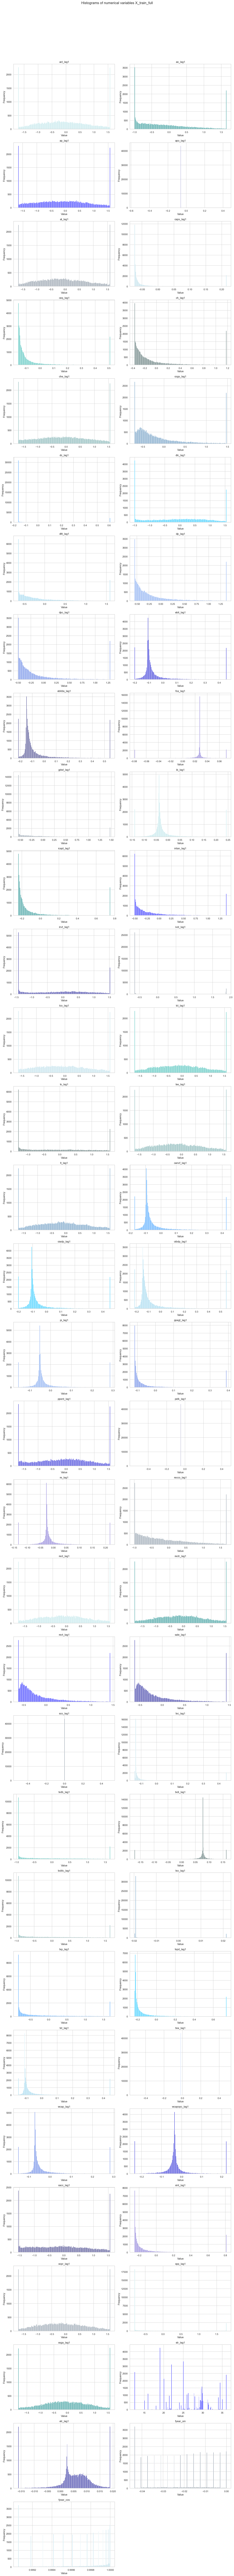

In [128]:
 # Plotting general plots for the numerical variables
sns.set_style("whitegrid")

numerical_columns = X_train_full_num.columns
num_plots = len(numerical_columns)
num_cols = 2
num_rows = -(-num_plots // num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

# Plotting each histogram
for i, col in enumerate(numerical_columns):
    ax = axes[i]
    data = X_train_full_num[col].dropna()

    # Adjusting the bins based on the variation in the data
    data_range = data.max() - data.min()
    if data_range > 0:
        num_bins = int(np.sqrt(len(data)))
    else:
        num_bins = 10
    
    # Using 5th to 95th percentiles for variables with outliers
    data = np.clip(data, data.quantile(0.05), data.quantile(0.95))

    # Plotting the histogram
    ax.hist(data, bins=num_bins, color=color_codes[i % len(color_codes)])
    ax.set_title(col, fontsize=12)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Removing any unused subplots
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Histograms of numerical variables X_train_full", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [129]:
# Re-checking for missing values in the datasets
print('Number of NaN values in X_train_full: ', X_train_full.isnull().sum().sum())
print('Number of NaN values in X_train: ', X_train.isnull().sum().sum())
print('Number of NaN values in X_train: ', X_val.isnull().sum().sum())
print('Number of NaN values in X_test: ', X_test.isnull().sum().sum())
print('Number of NaN values in y_train_full: ', y_train_full.isnull().sum().sum())
print('Number of NaN values in y_train: ', y_train.isnull().sum().sum())
print('Number of NaN values in y_train: ', y_val.isnull().sum().sum())
print('Number of NaN values in y_test: ', y_test.isnull().sum().sum())

Number of NaN values in X_train_full:  0
Number of NaN values in X_train:  0
Number of NaN values in X_train:  0
Number of NaN values in X_test:  0
Number of NaN values in y_train_full:  0
Number of NaN values in y_train:  0
Number of NaN values in y_train:  0
Number of NaN values in y_test:  0


In [130]:
# Re-checking for infinite values in the datasets
print('Number of infinite values in X_train: ', X_train_full[X_train_full == np.inf].count().sum())
print('Number of infinite values in X_train: ', X_train[X_train == np.inf].count().sum())
print('Number of infinite values in X_val: ', X_val[X_val == np.inf].count().sum())
print('Number of infinite values in X_test: ', X_test[X_test == np.inf].count().sum())

Number of infinite values in X_train:  0
Number of infinite values in X_train:  0
Number of infinite values in X_val:  0
Number of infinite values in X_test:  0


### Checking the datasets

In [131]:
# Checking the datasets
print(X_train_full.shape)
print(y_train_full.shape)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(43522, 77)
(43522,)
(34818, 77)
(34818,)
(8704, 77)
(8704,)
(7445, 77)
(7445,)


# Saving the pre-processed dataset

In [132]:
# Saving for tax_avoidance
X_train_full = X_train_full.to_csv('X_train_full.csv')
X_train = X_train.to_csv('X_train.csv')
X_val = X_val.to_csv('X_val.csv')
X_test = X_test.to_csv('X_test.csv')
y_train_full = y_train_full.to_csv('y_train_full.csv')
y_train = y_train.to_csv('y_train.csv')
y_val = y_val.to_csv('y_val.csv')
y_test = y_test.to_csv('y_test.csv')